1. Check this tutorial for Markow Chains: https://setosa.io/ev/markov-chains/
2. Metropolis Hastings Algorithm: https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/
3. For Adaptive Metropolis algorithm: https://drops.dagstuhl.de/storage/16dagstuhl-seminar-proceedings/dsp-vol10361/DagSemProc.10361.3/DagSemProc.10361.3.pdf & Heikki Haario. Eero Saksman. Johanna Tamminen. "An adaptive Metropolis algorithm." Bernoulli 7 (2) 223 - 242, April 2001.
4. For Delayed Rejection and DRAM:
  1. http://helios.fmi.fi/~lainema/dram/
  2. https://mjlaine.github.io/mcmcstat/
  3. http://helios.fmi.fi/~lainema/dram/#code
  4. A. Mira, 2001a. On Metropolis-Hastings algorithm with delayed rejection Metron, Vol. LIX, 3-4, pp. 231-241.



# Library Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
from scipy.integrate import odeint # for reference trajectory generation
from scipy.integrate import solve_ivp # for reference trajectory generation
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pickle
import statsmodels.api as sm

# Question 1

## Metropolis Hastings Algorithm

In [ ]:
# k is the number of iterations you want to run
def Metropolis_Hastings(initial_val, proposal_covar, k, burnpercent, target_density):

    # create variables to store number of accepted and rejected samples
    accepted, rejected = 0, 0

    # define the samples
    samples = np.zeros((k, 2))
    samples[0] = initial_val

    # define burn index
    burn = int(burnpercent * k/100)

    # start the sampling loop
    for j in tqdm(range(k-1)):

        # generate next sample from the proposal
        next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=proposal_covar)

        # compute the target density ratio i.e p(next_sample)/p(current_sample)
        target_ratio = target_density(next_sample)/target_density(samples[j])

        # compute the proposal density ratio i.e q(next_sample | current_sample)/q(current_sample | next_sample)
        proposal_next_given_curr = stats.multivariate_normal.pdf(next_sample, mean=samples[j], cov=proposal_covar)
        proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=next_sample, cov=proposal_covar)
        proposal_ratio = proposal_next_given_curr/proposal_curr_given_next

        # compute alpha
        alpha = min(1, target_ratio * proposal_ratio)

        # accept candidate, i.e store curr = cand with probability alpha
        if np.random.uniform() < alpha:
          # accept the next sample, add it to samples
          samples[j+1] = next_sample
          accepted += 1
        else:
          # reject the next sample, add current sample to samples again
          samples[j+1] = samples[j]
          rejected += 1

    # return the samples after burn-in
    samples = np.array(samples)
    return samples[burn:], accepted, rejected

# implement a function to calculate auto-correlation of a chain
def autocorrval(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))[0, 1]

In [ ]:
# define target density of simple banana shaped distribution
def target_banana(x):

  xx, xy = x

  # apply banana transformation
  xy = xy + (xx**2 + 1)

  # find probability
  prob = stats.multivariate_normal.pdf([xx, xy], mean=[0, 0], cov=[[1, 0.9], [0.9, 1]])

  return prob

In [ ]:
MH_chain, MH_accepted, MH_rejected = Metropolis_Hastings([0, 0], np.eye(2), 100000, 20, target_banana)

100%|██████████| 99999/99999 [02:00<00:00, 830.81it/s]


## Adaptive Metropolis Algorithm

In [ ]:
  # k is the number of iterations you want to run
def Adaptive_Metropolis_Hastings(initial_val, proposal_covar, k, burnpercent, target_density, t0, epsilon):

    # define variables which count the number of accepted and rejected samples
    accepted, rejected = 0, 0

    # define the samples
    samples = np.zeros((k, 2))
    samples[0] = initial_val

    # define burn index
    burn = int(burnpercent * k/100)

    # define adaptation time
    t0 = int(k*t0/100)

    # start the sampling loop
    for j in tqdm(range(t0)):

        # generate next sample from the proposal
        next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=proposal_covar)

        # compute the target density ratio i.e p(next_sample)/p(current_sample)
        target_ratio = target_density(next_sample)/target_density(samples[j])

        # compute the proposal density ratio i.e q(next_sample | current_sample)/q(current_sample | next_sample)
        proposal_next_given_curr = stats.multivariate_normal.pdf(next_sample, mean=samples[j], cov=proposal_covar)
        proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=next_sample, cov=proposal_covar)
        proposal_ratio = proposal_next_given_curr/proposal_curr_given_next

        # compute alpha
        alpha = min(1, target_ratio * proposal_ratio)

        # accept candidate, i.e store curr = cand with probability alpha
        if np.random.uniform() < alpha:
          # accept the next sample, add it to samples
          samples[j+1] = next_sample
          accepted += 1
        else:
          # reject the next sample, add current sample to samples again
          samples[j+1] = samples[j]
          rejected += 1

    # define parameters for Adaptive Metropolis
    d = 2 # dimension of the random variable
    sd = (2.4**2)/d
    Id = np.eye(d)

    for j in tqdm(range(t0, k-1)):

        # update covariance
        proposal_covar = sd * np.cov(np.array(samples[:j]).T) + sd * epsilon * Id

        # generate next sample from the proposal
        next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=proposal_covar)

        # compute the target density ratio i.e p(next_sample)/p(current_sample)
        target_ratio = target_density(next_sample)/target_density(samples[j])

        # compute the proposal density ratio i.e q(next_sample | current_sample)/q(current_sample | next_sample)
        proposal_next_given_curr = stats.multivariate_normal.pdf(next_sample, mean=samples[j], cov=proposal_covar)
        proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=next_sample, cov=proposal_covar)
        proposal_ratio = proposal_next_given_curr/proposal_curr_given_next

        # compute alpha
        alpha = min(1, target_ratio * proposal_ratio)

        # accept candidate, i.e store curr = cand with probability alpha
        if np.random.uniform() < alpha:
          # accept the next sample, add it to samples
          samples[j+1] = next_sample
          accepted += 1
        else:
          # reject the next sample, add current sample to samples again
          samples[j+1] = samples[j]
          rejected += 1

    # return the samples after burn-in
    samples = np.array(samples)
    return samples[burn:], accepted, rejected

In [ ]:
Adaptive_MH_chain, AMH_accepted, AMH_rejected = Adaptive_Metropolis_Hastings([0.3, 0.3], np.eye(2), 100000, 20, target_banana, 30, 0.1)

100%|██████████| 69999/69999 [05:12<00:00, 224.31it/s]


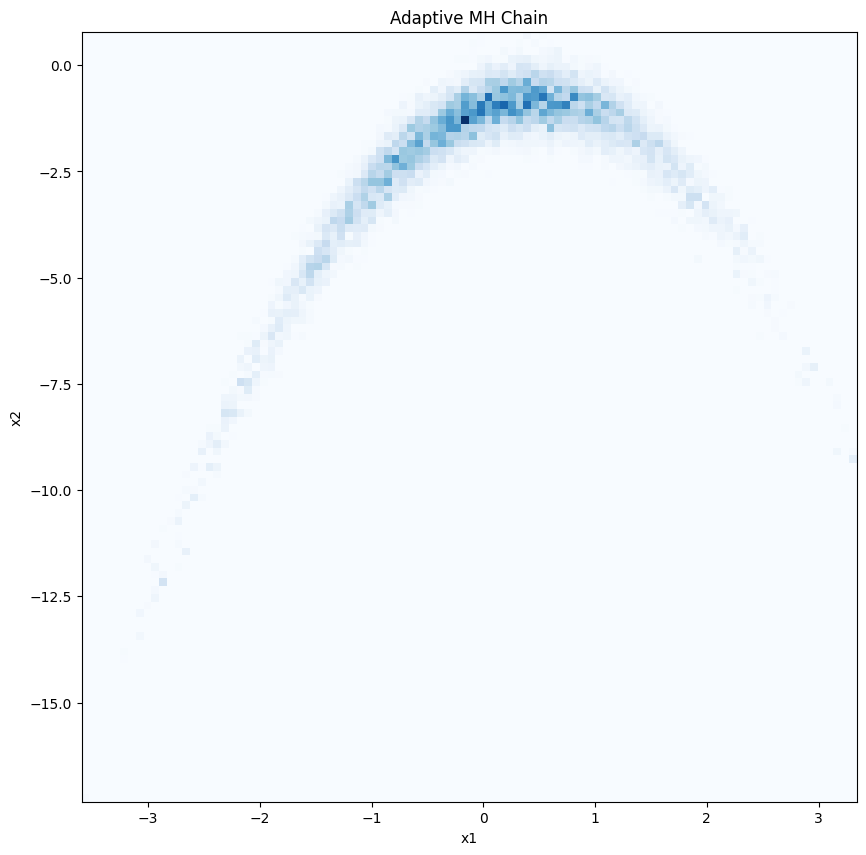

In [ ]:
# plot a 2D histogram of MH_chain, add titles, colorbars, also plot the known posterior, overlay on top of each other
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(Adaptive_MH_chain[:, 0], Adaptive_MH_chain[:, 1], bins=100, cmap='Blues')
ax.set_title('Adaptive MH Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

## Delayed Rejection

Read MIRA etal that should be enough

In [ ]:
def Delayed_Rejection(initial_val, proposal_covar, k, burnpercent, target_density, t0, gamma):

    # create variables to store number of accepted and rejected samples
    accepted, rejected = 0, 0

    # define the samples
    samples = np.zeros((k, 2))
    samples[0] = initial_val

    # define burn index
    burn = int(burnpercent * k/100)

    # start the sampling loop
    for j in tqdm(range(k-1)):

        # generate next sample from the proposal
        next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=proposal_covar)

        # compute the target density ratio i.e p(next_sample)/p(current_sample)
        target_ratio = target_density(next_sample)/target_density(samples[j])

        # compute the proposal density ratio i.e q1(next_sample | current_sample)/q(current_sample | next_sample)
        proposal_next_given_curr = stats.multivariate_normal.pdf(next_sample, mean=samples[j], cov=proposal_covar)
        proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=next_sample, cov=proposal_covar)
        proposal_ratio = proposal_next_given_curr/proposal_curr_given_next

        # compute alpha
        alpha = min(1, target_ratio * proposal_ratio)

        # accept candidate, i.e store curr = cand with probability alpha
        if np.random.uniform() < alpha:
          # accept the next sample, add it to samples
          samples[j+1] = next_sample

          accepted += 1
        else:

          # candidate at level 1 is rejected, go to level 2

          # create a new proposal with covariance scaled down with gamma
          l2_proposal_covar = gamma * proposal_covar

          # generate next sample from the l2_proposal
          l2_next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l2_proposal_covar)

          # compute the target density ratio i.e p(next_sample)/p(current_sample)
          l2_target_ratio = target_density(l2_next_sample)/target_density(samples[j])

          # compute the new proposal density ratio i.e q2(l2_next_sample | current_sample)/q(current_sample | l2_next_sample)
          l2_proposal_next_given_curr = stats.multivariate_normal.pdf(l2_next_sample, mean=samples[j], cov=l2_proposal_covar)
          l2_proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=l2_next_sample, cov=l2_proposal_covar)
          l2_proposal_ratio = l2_proposal_next_given_curr/l2_proposal_curr_given_next

          # compute alpha
          l2_alpha = min(1, l2_target_ratio * l2_proposal_ratio)

          if np.random.uniform() < l2_alpha:
            # accept the next sample, add it to samples
            samples[j+1] = l2_next_sample
            accepted += 1
          else:
            # reject the next sample, add current sample to samples again
            samples[j+1] = samples[j]
            rejected += 1

    # return the samples after burn-in
    samples = np.array(samples)
    return samples[burn:], accepted, rejected


In [ ]:
DR_MH_chain, DR_MH_accepted, DR_MH_rejected = Delayed_Rejection([0.3, 0.3], np.eye(2), 10000, 20, target_banana, 30, 0.5)

100%|██████████| 9999/9999 [00:20<00:00, 496.51it/s]


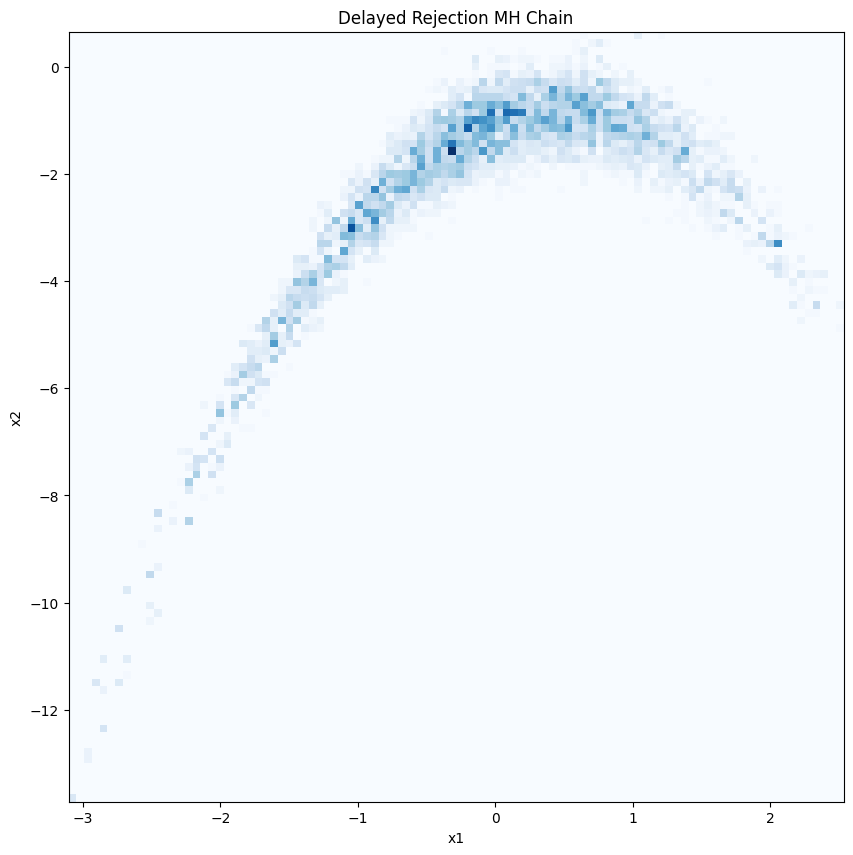

In [ ]:
# plot a 2D histogram of MH_chain, add titles, colorbars, also plot the known posterior, overlay on top of each other
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(DR_MH_chain[:, 0], DR_MH_chain[:, 1], bins=100, cmap='Blues')
ax.set_title('Delayed Rejection MH Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

## Delayed Rejection Adaptive Metropolis Hastings

In [ ]:
def Delayed_Rejection_Adaptive_Metropolis(initial_val, proposal_covar, k, burnpercent, target_density, t0, gamma, epsilon):

    accepted, rejected = 0, 0

    # define the samples
    samples = np.zeros((k, 2))
    samples[0] = initial_val

    # define burn index
    burn = int(burnpercent * k/100)

    # start the sampling loop
    for j in tqdm(range(k-1)):

        # high level proposal workflow

        # generate next sample from the proposal
        next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=proposal_covar)

        # compute the target density ratio i.e p(next_sample)/p(current_sample)
        target_ratio = target_density(next_sample)/target_density(samples[j])

        # compute the proposal density ratio i.e q1(next_sample | current_sample)/q(current_sample | next_sample)
        proposal_next_given_curr = stats.multivariate_normal.pdf(next_sample, mean=samples[j], cov=proposal_covar)
        proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=next_sample, cov=proposal_covar)
        proposal_ratio = proposal_next_given_curr/proposal_curr_given_next

        # compute alpha: acceptance probability
        alpha = min(1, target_ratio * proposal_ratio)

        # accept candidate, i.e store curr = cand with probability alpha
        if np.random.uniform() < alpha:

          # if accepted update the curent_state
          samples[j+1] = next_sample

          accepted += 1

          # invoke adaptive algorithm
          # define parameters for Adaptive Metropolis
          d = 2 # dimension of the random variable
          sd = (2.4**2)/d
          Id = np.eye(d)

          # update covariance matrix
          am_proposal_covar = sd * np.cov(np.array(samples[:j+1]).T) + sd * epsilon * Id
          proposal_covar = am_proposal_covar

        else:

          # candidate at level 1 is rejected, go to level 2 proposal

          # create a new proposal with covariance scaled down with gamma
          l2_proposal_covar = gamma * proposal_covar

          # generate next sample from the l2_proposal
          l2_next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l2_proposal_covar)

          # compute the target density ratio i.e p(next_sample)/p(current_sample)
          l2_target_ratio = target_density(l2_next_sample)/target_density(samples[j])

          # compute the new proposal density ratio i.e q2(l2_next_sample | current_sample)/q(current_sample | l2_next_sample)
          l2_proposal_next_given_curr = stats.multivariate_normal.pdf(l2_next_sample, mean=samples[j], cov=l2_proposal_covar)
          l2_proposal_curr_given_next = stats.multivariate_normal.pdf(samples[j], mean=l2_next_sample, cov=l2_proposal_covar)
          l2_proposal_ratio = l2_proposal_next_given_curr/l2_proposal_curr_given_next

          # compute alpha
          l2_alpha = min(1, l2_target_ratio * l2_proposal_ratio)

          if np.random.uniform() < l2_alpha:
            # accept the next sample, add it to samples
            samples[j+1] = l2_next_sample
            accepted += 1
          else:
            # reject the next sample, add current sample to samples again
            samples[j+1] = samples[j]
            rejected += 1

    # return the samples after burn-in
    samples = np.array(samples)
    return samples[burn:], accepted, rejected

In [ ]:
DRAM_MH_chain, DRAM_MH_accepted, DRAM_MH_rejected = Delayed_Rejection_Adaptive_Metropolis([0.3, 0.3], np.eye(2), 10000, 20, target_banana, 30, 0.5, 0.1)

100%|██████████| 9999/9999 [00:23<00:00, 421.48it/s]


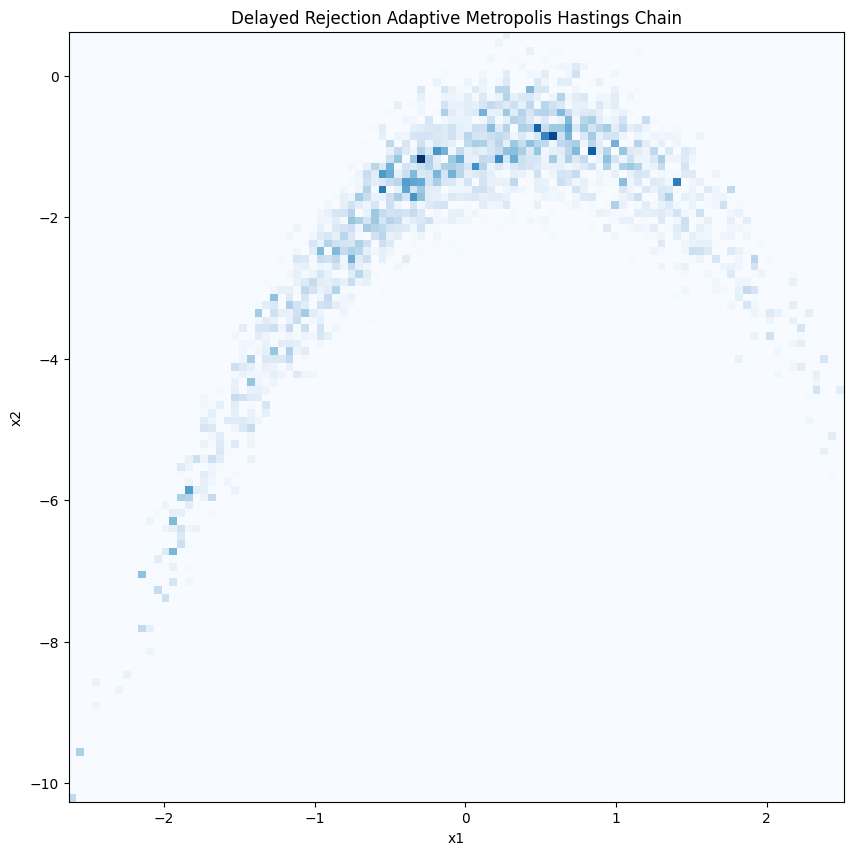

In [ ]:
# plot a 2D histogram of MH_chain, add titles, colorbars, also plot the known posterior, overlay on top of each other
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist2d(DRAM_MH_chain[:, 0], DRAM_MH_chain[:, 1], bins=100, cmap='Blues')
ax.set_title('Delayed Rejection Adaptive Metropolis Hastings Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

## Diagnostics

### MH Algorithm

#### 2D Histogram

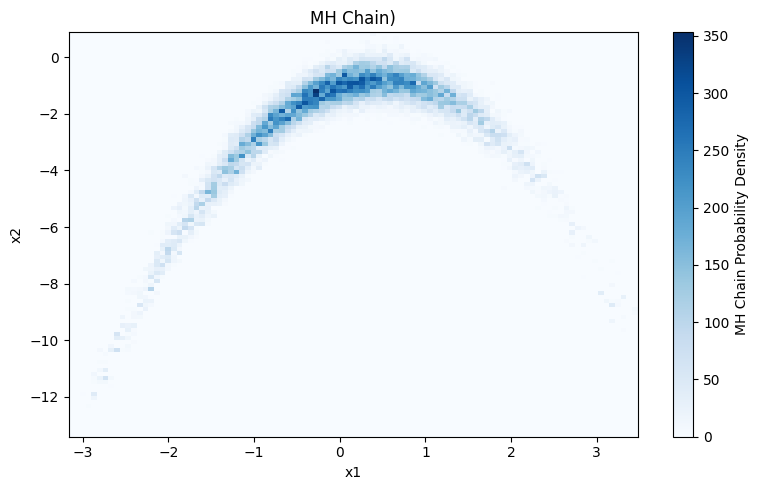

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot MH chain histogram
h = ax.hist2d(MH_chain[:, 0], MH_chain[:, 1], bins=100, cmap='Blues')

# Add titles and labels
ax.set_title('MH Chain)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Add colorbar for MH chain
cbar = plt.colorbar(h[3], ax=ax, label='MH Chain Probability Density')

# Improve image quality by saving as PNG
plt.tight_layout()  # Adjust layout to avoid clipping labels
plt.savefig('mh_chain_vs_posterior.png', dpi=500)  # Save as high-resolution PNG

# Optionally, you can still display the plot
plt.show()

#### 1D and 2D Marginals

In [ ]:
def plot_marginals(samples, algo_string):

    num_parameters = samples.shape[1]

    # 2D Marginal plots for each pair of parameters
    fig, ax = plt.subplots(num_parameters, num_parameters, figsize=(5 * num_parameters, 5 * num_parameters))
    for i in range(num_parameters):
        for j in range(num_parameters):
            if i == j:
                # plot 1D marginal on the diagonal (histogram)
                ax[i, j].hist(samples[:, i], bins=50, density=True, alpha=0.7, color='skyblue')
                ax[i, j].set_title(r"%s: 1D Marginal: Distribution of $x_{%.0f}$" %(algo_string, (i + 1)))
            elif i < j:
                # plot 2D scatter for pairs of parameters (upper triangle)
                ax[i, j].scatter(samples[:, i], samples[:, j], alpha=0.3, color='coral')
                ax[i, j].set_xlabel(r"$x_{%.0f}$" % (i + 1))
                ax[i, j].set_ylabel(r"$x_{%.0f}$" % (j + 1))
                ax[i, j].set_title(r"%s: 2D Marginal: $x_{%.0f}$ vs $x_{%.0f}$" % (algo_string, i + 1, j + 1))
            else:
                # Hide the lower triangle
                ax[i, j].axis("off")

    plt.tight_layout()
    # save plot with high resolution
    plt.savefig(f'{algo_string}_marginals.png', dpi=300)  # Save as high-resolution PNG
    plt.show()

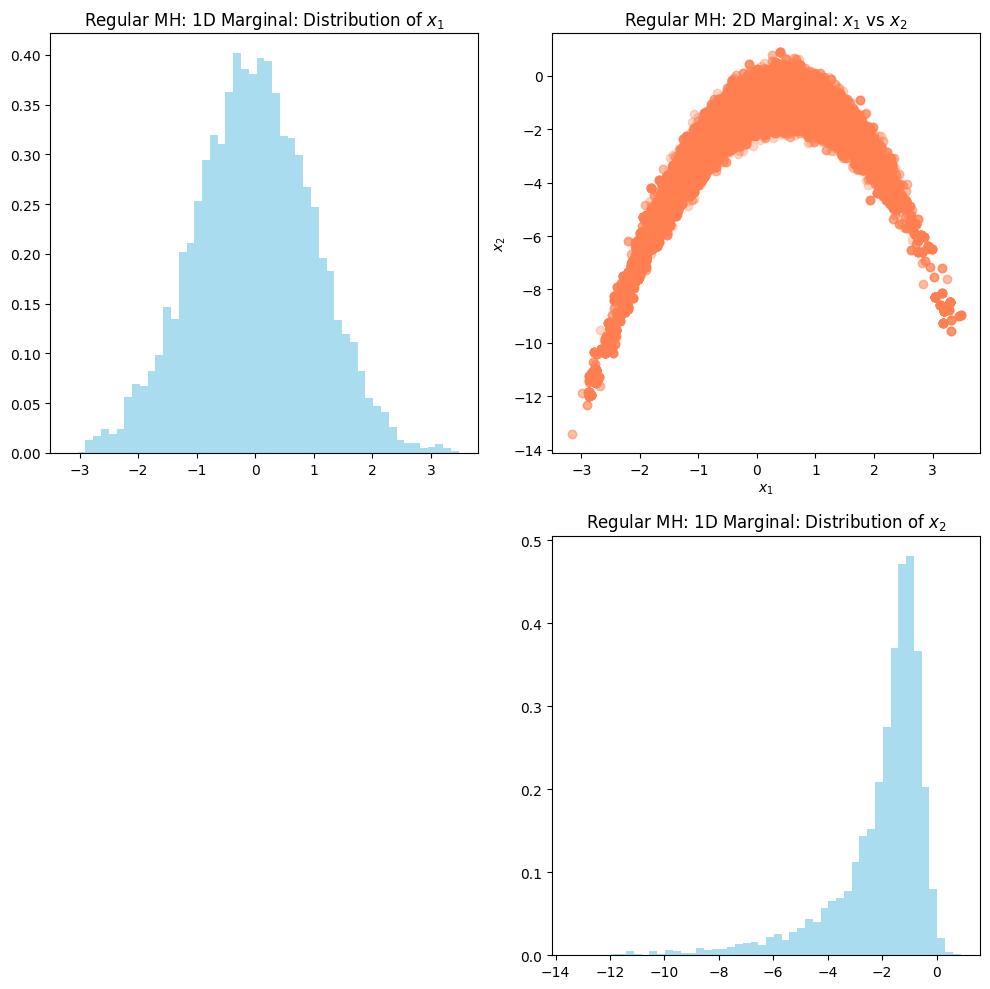

In [ ]:
plot_marginals(MH_chain, "Regular MH")

#### Auto-corelation plots

In [ ]:
def plot_autocorrelation(mh_chain, save_string, max_lag=50):
    """
    Plots the autocorrelation for each parameter in the MCMC chain.

    Args:
        mh_chain (numpy.ndarray): MCMC chain with shape (num_samples, num_parameters).
        max_lag (int): Maximum lag to compute autocorrelation (default is 50).
    """
    num_parameters = mh_chain.shape[1]
    fig, axs = plt.subplots(num_parameters, 1, figsize=(8, 4 * num_parameters))

    for i in range(num_parameters):
        ax = axs[i] if num_parameters > 1 else axs  # Handle single parameter case
        plot_acf(mh_chain[:, i], lags=max_lag, ax=ax)
        ax.set_title(f"{save_string} Autocorrelation for Parameter {i+1}")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")

    plt.tight_layout()
    plt.savefig(f"Auto-corelation plots of {save_string}.png", dpi=300)
    plt.show()

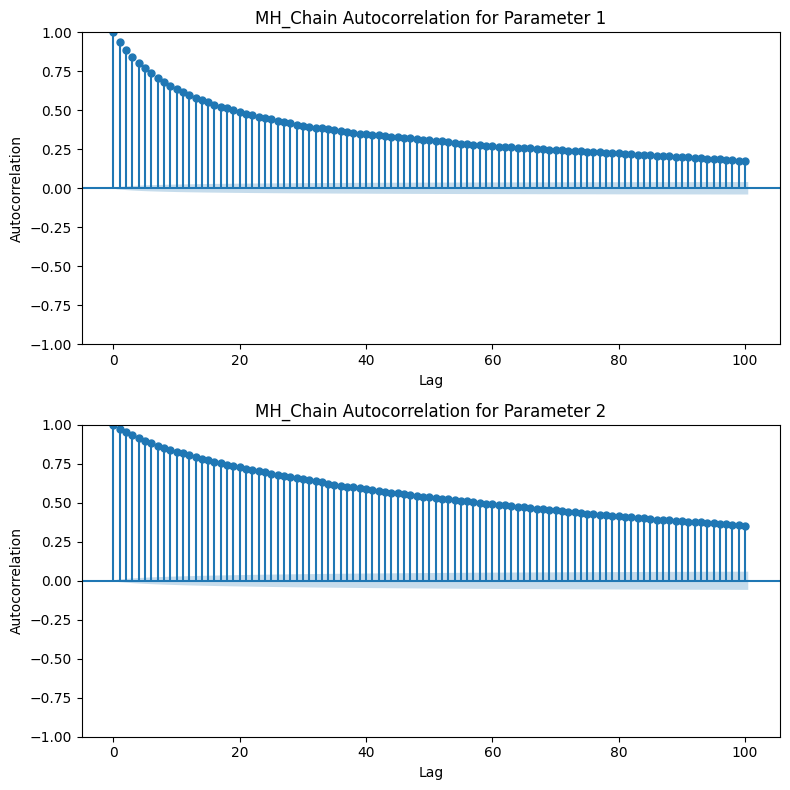

In [ ]:
plot_autocorrelation(MH_chain, "MH_Chain", max_lag=100)

#### Integrated Auto-corelation time plots

In [ ]:
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.stattools import acf
import numpy as np

def calculate_iat(samples, max_lag=50):
    """
    Calculates the integrated autocorrelation time (IAT) for each parameter in the MCMC chain.

    Args:
        samples: A numpy array of shape (num_iterations, num_parameters).
        max_lag: Maximum lag to consider for autocorrelation (default is 50).

    Returns:
        A list of IAT values for each parameter.
    """
    num_parameters = samples.shape[1]
    iats = []

    for i in range(num_parameters):
        # Compute the autocorrelation function up to max_lag
        acf_values = acf(samples[:, i], nlags=max_lag, fft=True)
        # Calculate the IAT
        iat = 1 + 2 * np.sum(acf_values[1:])  # Sum over all lags excluding lag 0
        iats.append(iat)

    return iats

In [ ]:
calculate_iat(MH_chain)

[49.964153038522525, 71.41621886897956]

#### Acceptance Ratios

need to make changes in the original algoithms to keep track of how many were accepted or rejected.

In [ ]:
# compute acceptance ratio of MH chain
MH_acceptance_ratio = MH_accepted/MH_chain.shape[0]
print(f"Acceptance Ratio: {MH_acceptance_ratio}")

Acceptance Ratio: 0.3269125


#### Visual Inspection of Mixing

### Adaptive MH Algorithm

#### 2D Histogram

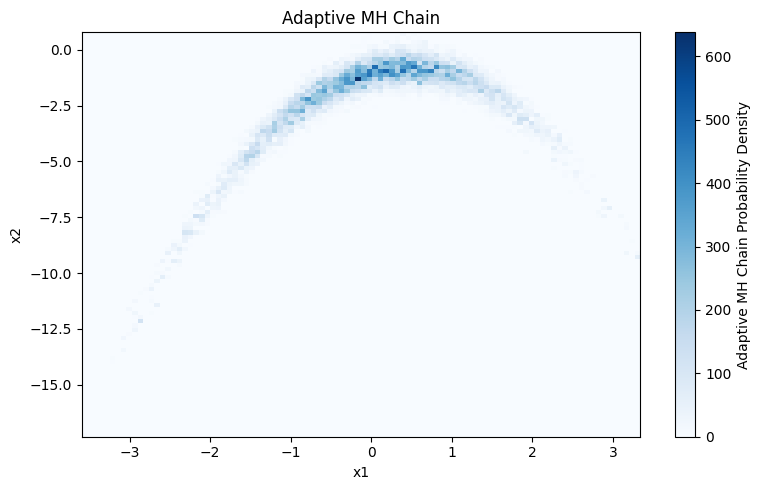

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot MH chain histogram
h = ax.hist2d(Adaptive_MH_chain[:, 0], Adaptive_MH_chain[:, 1], bins=100, cmap='Blues')

# Add titles and labels
ax.set_title('Adaptive MH Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Add colorbar for MH chain
cbar = plt.colorbar(h[3], ax=ax, label='Adaptive MH Chain Probability Density')

# Improve image quality by saving as PNG
plt.tight_layout()  # Adjust layout to avoid clipping labels
plt.savefig('amh_chain_2d_histogram.png', dpi=500)  # Save as high-resolution PNG

# Optionally, you can still display the plot
plt.show()

#### 1D and 2D Marginals

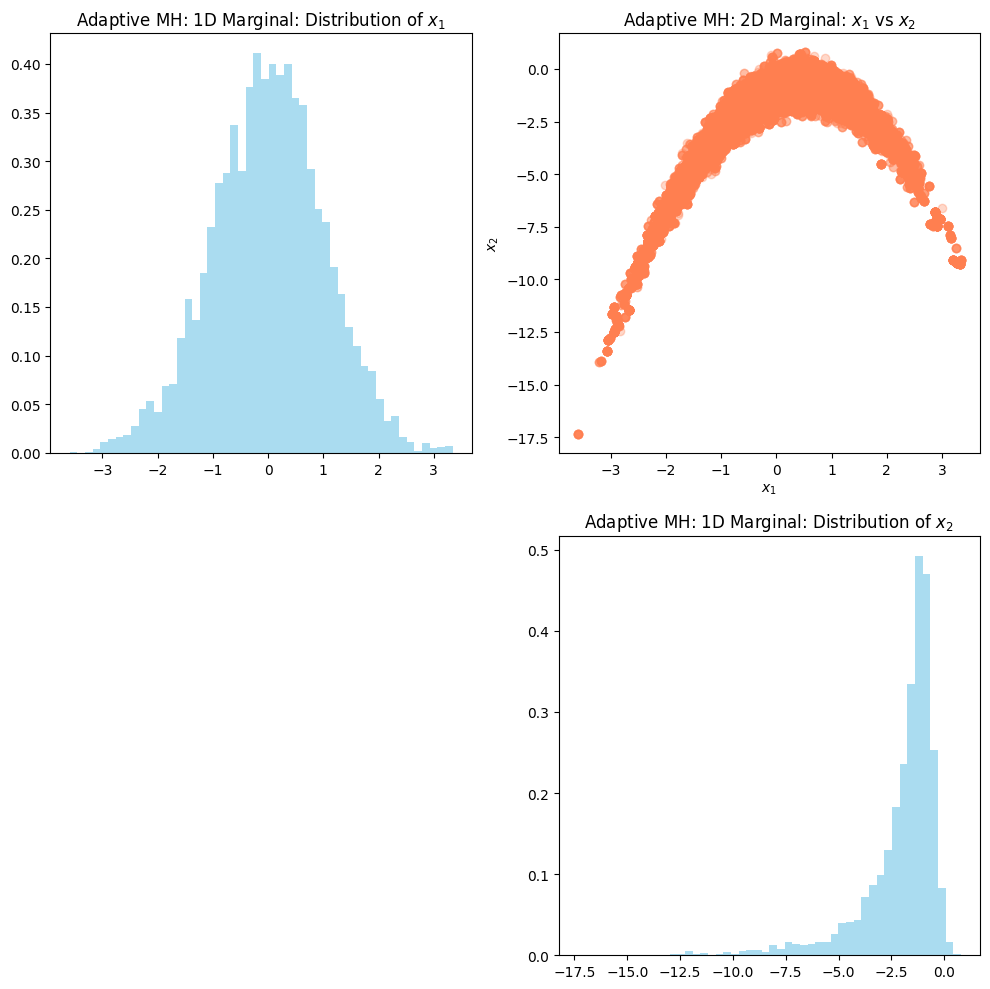

In [ ]:
plot_marginals(Adaptive_MH_chain, "Adaptive MH")

#### Auto-corelation plots

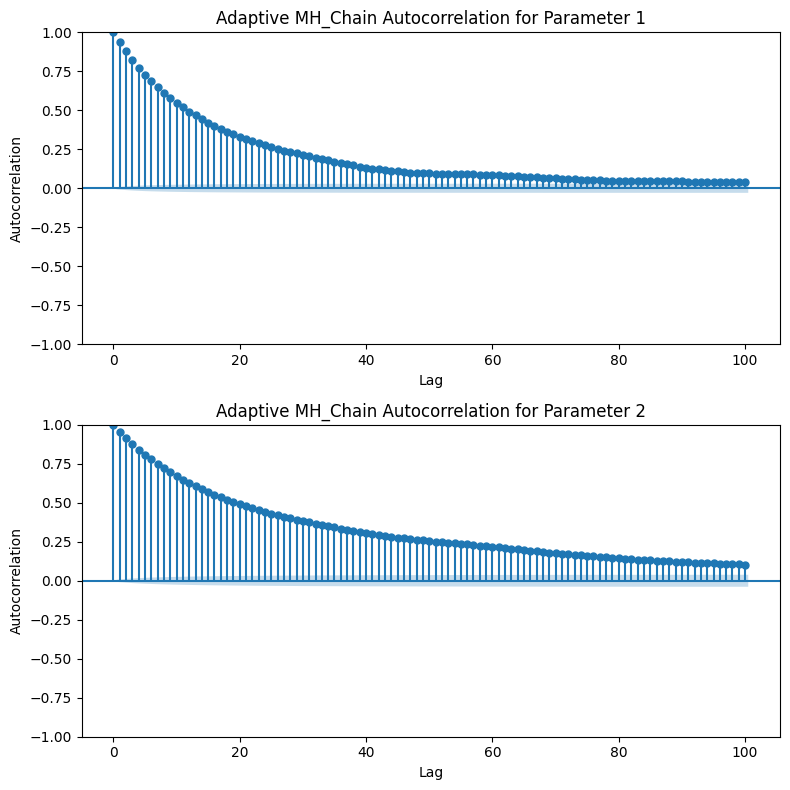

In [ ]:
plot_autocorrelation(Adaptive_MH_chain, "Adaptive MH_Chain", max_lag=100)

#### Integrated Auto-corelation values

In [ ]:
calculate_iat(Adaptive_MH_chain)

[34.459938830135506, 49.15211613211621]

#### Acceptance Ratios

In [ ]:
# compute acceptance ratio of MH chain
AMH_acceptance_ratio = AMH_accepted/Adaptive_MH_chain.shape[0]
print(f"Acceptance Ratio: {AMH_acceptance_ratio}")

Acceptance Ratio: 0.19195


#### Visual Inspection of Mixing

### Delayed Rejection Algorithm

#### 2D Histogram

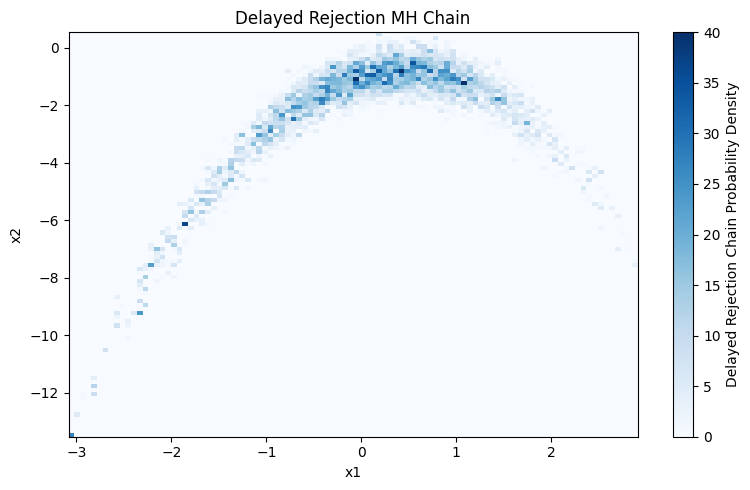

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot MH chain histogram
h = ax.hist2d(DR_MH_chain[:, 0], DR_MH_chain[:, 1], bins=100, cmap='Blues')

# Add titles and labels
ax.set_title('Delayed Rejection MH Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Add colorbar for MH chain
cbar = plt.colorbar(h[3], ax=ax, label='Delayed Rejection Chain Probability Density')

# Improve image quality by saving as PNG
plt.tight_layout()  # Adjust layout to avoid clipping labels
plt.savefig('drmh_chain_2d_histogram.png', dpi=500)  # Save as high-resolution PNG

# Optionally, you can still display the plot
plt.show()

#### 1D and 2D Marginals

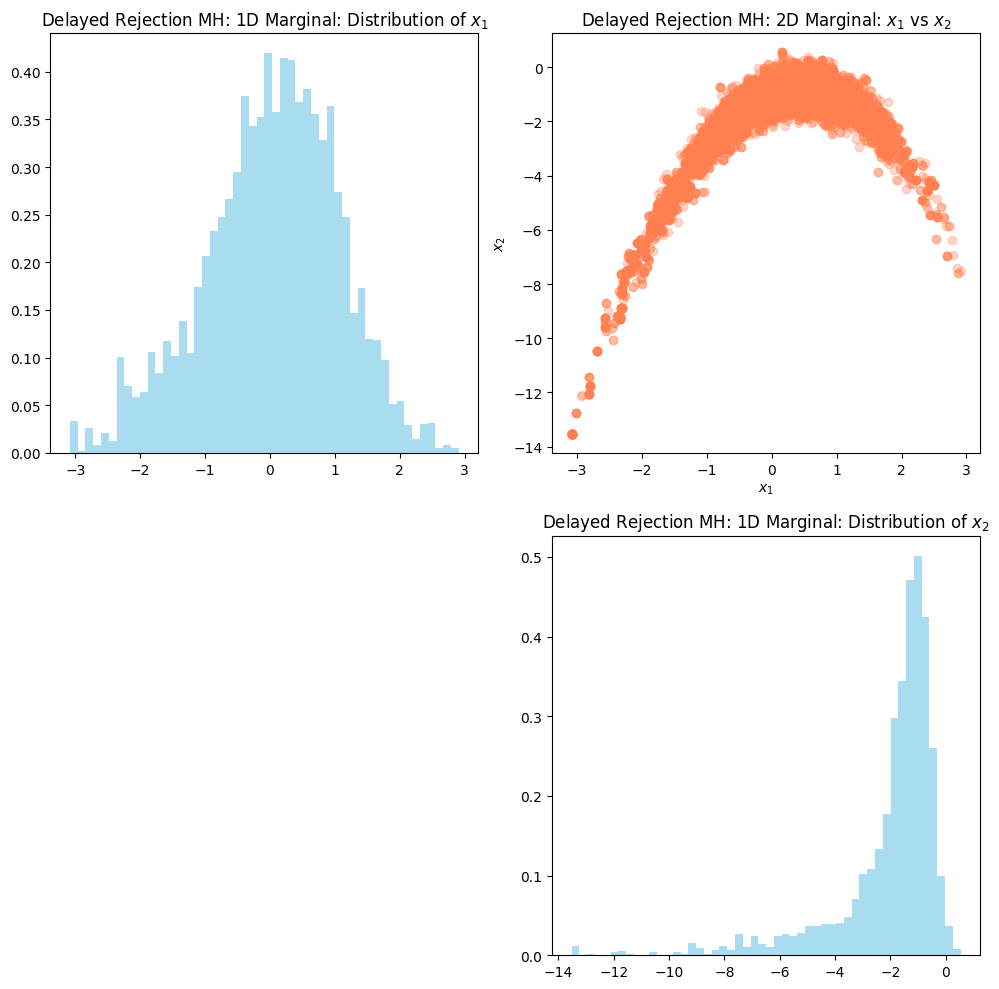

In [ ]:
plot_marginals(DR_MH_chain, "Delayed Rejection MH")

#### Auto-corelation plots

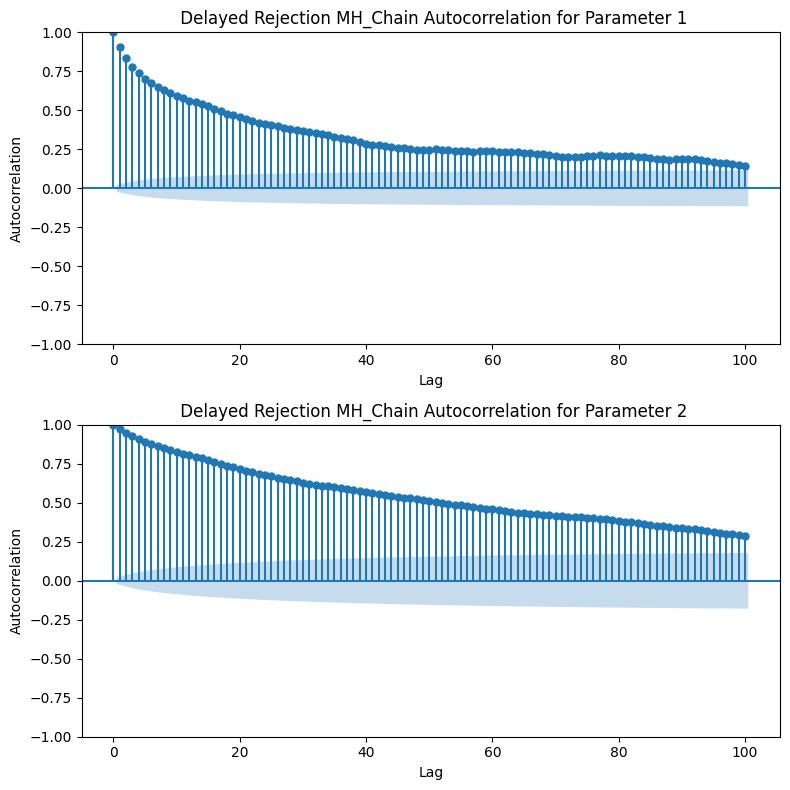

In [ ]:
plot_autocorrelation(DR_MH_chain, " Delayed Rejection MH_Chain", max_lag=100)

#### Integrated Auto-corelation values

In [ ]:
calculate_iat(DR_MH_chain)

[45.289250949790016, 70.10487666725737]

#### Acceptance Ratios

In [ ]:
# compute acceptance ratio of MH chain
DRMH_acceptance_ratio = DR_MH_accepted/DR_MH_chain.shape[0]
print(f"Acceptance Ratio: {DRMH_acceptance_ratio}")

Acceptance Ratio: 0.639375


#### Visual Inspection of Mixing

### DRAM Algorithm

#### 2D Histogram

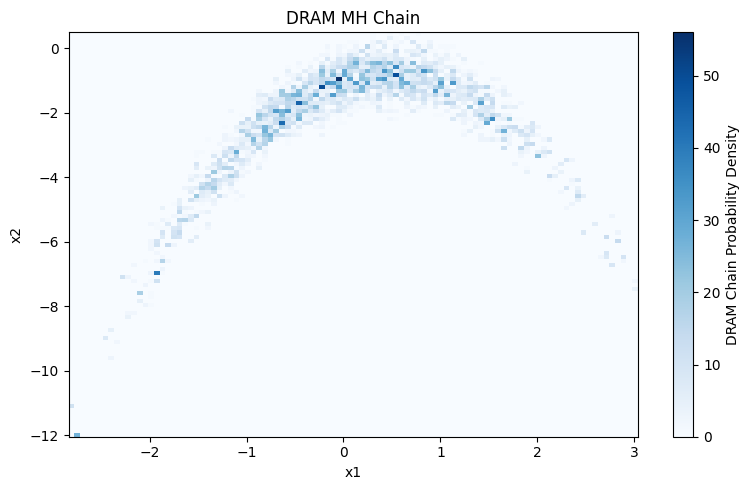

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot MH chain histogram
h = ax.hist2d(DRAM_MH_chain[:, 0], DRAM_MH_chain[:, 1], bins=100, cmap='Blues')

# Add titles and labels
ax.set_title('DRAM MH Chain')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Add colorbar for MH chain
cbar = plt.colorbar(h[3], ax=ax, label='DRAM Chain Probability Density')

# Improve image quality by saving as PNG
plt.tight_layout()  # Adjust layout to avoid clipping labels
plt.savefig('dram_chain_2d_histogram.png', dpi=500)  # Save as high-resolution PNG

# Optionally, you can still display the plot
plt.show()

#### 1D and 2D Marginals

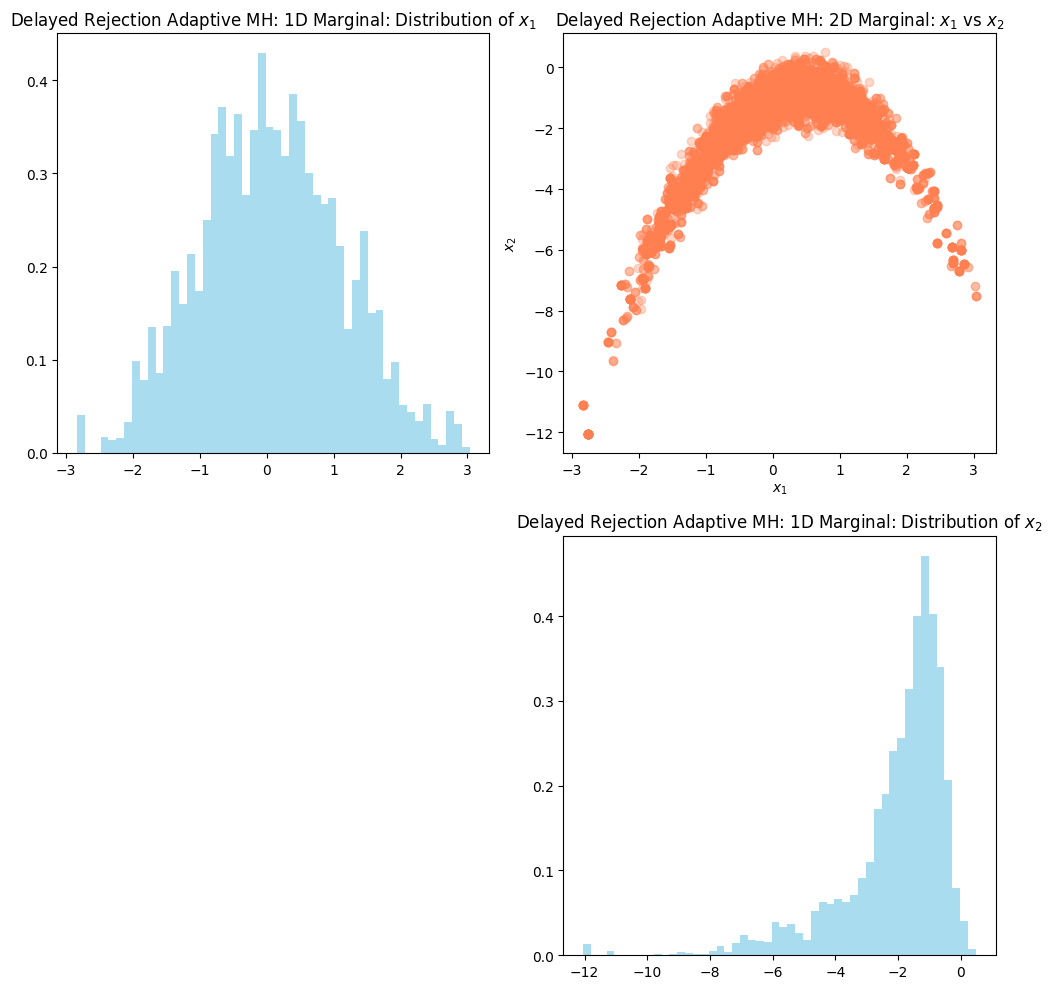

In [ ]:
plot_marginals(DRAM_MH_chain, "Delayed Rejection Adaptive MH")

#### Auto-corelation plots

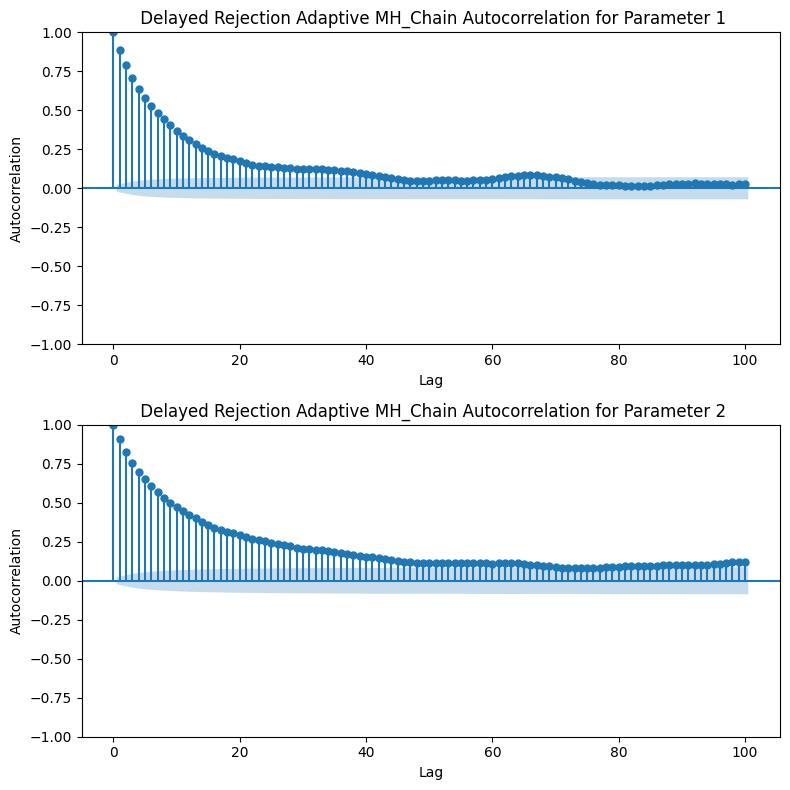

In [ ]:
plot_autocorrelation(DRAM_MH_chain, " Delayed Rejection Adaptive MH_Chain", max_lag=100)

#### Integrated Auto-corelation values

In [ ]:
calculate_iat(DRAM_MH_chain)

[23.719241959678204, 32.15855386304952]

#### Acceptance Ratios

In [ ]:
# compute acceptance ratio of MH chain
DRAM_acceptance_ratio = DRAM_MH_accepted/DRAM_MH_chain.shape[0]
print(f"Acceptance Ratio: {DRAM_acceptance_ratio}")

Acceptance Ratio: 0.377875


#### Visual Inspection of Mixing

## Comparison and Tuning

In [ ]:
def get_autocorrelation(parameter_values, max_lag=50):
  """
  Calculates the autocorrelation function for a given parameter.

  Args:
      parameter_values (numpy.ndarray): An array of parameter values.
      max_lag (int, optional): Maximum lag to compute autocorrelation. Defaults to 50.

  Returns:
      numpy.ndarray: Autocorrelation function for the parameter.
  """

  autocorrelation = sm.tsa.acf(parameter_values, nlags=max_lag)
  return autocorrelation

In [ ]:
def calculate_average_decay_rate(autocorrelation, max_lag=50):
  """
  Calculates the average rate of decay in the autocorrelation function.

  Args:
      autocorrelation (numpy.ndarray): Autocorrelation function for a single parameter.
      max_lag (int, optional): Maximum lag considered. Defaults to 50.

  Returns:
      float: Average rate of decay in the autocorrelation.
  """
  # Exclude the first element (autocorrelation at lag 0 is always 1)
  decay_rates = np.diff(autocorrelation[:max_lag])

  # Avoid division by zero (in case autocorrelation is constant)
  if not decay_rates.any():
    return 0

  # Calculate average absolute decay rate
  average_decay_rate = np.mean(np.abs(decay_rates))

  return average_decay_rate

### Regular MH

In [ ]:
# tune initial proposal covariances:
k = 200000
covar_scales = np.array([0.1, 0.5, 0.9, 1.3, 2])
MH_IATs = np.zeros((len(covar_scales), 2))
auto_corr_rate = np.zeros((len(covar_scales), 2))
MH_acceptance_ratios = np.zeros(len(covar_scales))
effective_sample_size = np.zeros((len(covar_scales), 2))

for i in range(len(covar_scales)):
  MH_chain, MH_accepted, MH_rejected = Metropolis_Hastings([0, 0], np.eye(2)*covar_scales[i], k, 20, target_banana)
  MH_IATs[i] = calculate_iat(MH_chain)
  MH_acceptance_ratios[i] = MH_accepted/MH_chain.shape[0]
  for j in range(2):
    auto_corr_rate[i, j] = calculate_average_decay_rate(get_autocorrelation(MH_chain[:, j]))
    effective_sample_size[i, j] = k/MH_IATs[i, j]

100%|██████████| 199999/199999 [03:54<00:00, 851.65it/s]


In [ ]:
# pickle all these variables
import pickle
with open('MH_IATs.pkl', 'wb') as f:
    pickle.dump(MH_IATs, f)
with open('MH_acceptance_ratios.pkl', 'wb') as f:
    pickle.dump(MH_acceptance_ratios, f)
with open('MH_auto_corr_rate.pkl', 'wb') as f:
    pickle.dump(auto_corr_rate, f)
with open('MH_effective_sample_size.pkl', 'wb') as f:
    pickle.dump(effective_sample_size, f)

In [ ]:
MH_IATs

array([[79.2400883 , 91.20621428],
       [51.91147091, 69.53661739],
       [51.16861834, 71.23633317],
       [44.33140087, 62.03645181],
       [39.45066767, 58.79704376]])

In [ ]:
auto_corr_rate

array([[0.00690094, 0.00331394],
       [0.01396134, 0.00993694],
       [0.01389974, 0.00937796],
       [0.01550732, 0.0119183 ],
       [0.01648476, 0.0128502 ]])

In [ ]:
MH_acceptance_ratios*MH_chain.shape[0]/200000

array([0.59236 , 0.361605, 0.27819 , 0.231435, 0.18236 ])

In [ ]:
effective_sample_size

array([[2523.97497657, 2192.8330387 ],
       [3852.71302236, 2876.18247077],
       [3908.6456989 , 2807.55607565],
       [4511.47484789, 3223.91100956],
       [5069.6226916 , 3401.5315601 ]])

### Adaptive MH

In [ ]:
# tune initial proposal covariances:
k = 150000
t0_scales = np.array([20, 50])
epsilon_scales = np.array([0.1, 0.6])
AMH_IATs = np.zeros((len(t0_scales), len(epsilon_scales), 2))
AMH_auto_corr_rate = np.zeros((len(t0_scales), len(epsilon_scales), 2))
AMH_acceptance_ratios = np.zeros((len(t0_scales), len(epsilon_scales)))
AMH_effective_sample_size = np.zeros((len(t0_scales), len(epsilon_scales), 2))

for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    AMH_chain, AMH_accepted, AMH_rejected = Adaptive_Metropolis_Hastings([0.3, 0.3], np.eye(2), k, 20, target_banana, t0_scales[i], epsilon_scales[j])
    AMH_IATs[i, j] = calculate_iat(AMH_chain)
    AMH_acceptance_ratios[i, j] = AMH_accepted/AMH_chain.shape[0]
    for q in range(2):
      AMH_auto_corr_rate[i, j, q] = calculate_average_decay_rate(get_autocorrelation(AMH_chain[:, q]))
      AMH_effective_sample_size[i, j, q] = k/AMH_IATs[i, j, q]

100%|██████████| 74999/74999 [07:29<00:00, 166.78it/s]


In [ ]:
# pickle all variables
with open('AMH_IATs.pkl', 'wb') as f:
    pickle.dump(AMH_IATs, f)
with open('AMH_acceptance_ratios.pkl', 'wb') as f:
    pickle.dump(AMH_acceptance_ratios, f)
with open('AMH_auto_corr_rate.pkl', 'wb') as f:
    pickle.dump(AMH_auto_corr_rate, f)
with open('AMH_effective_sample_size.pkl', 'wb') as f:
    pickle.dump(AMH_effective_sample_size, f)

In [ ]:
for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    print(t0_scales[i], epsilon_scales[j])

20 0.1
20 0.6
50 0.1
50 0.6


In [ ]:
for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    print(AMH_IATs[i, j])

[41.58443019 70.1665857 ]
[34.69793999 52.70503527]
[38.92090549 55.68401847]
[41.70847608 57.12284328]


In [ ]:
for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    print(AMH_auto_corr_rate[i, j])

[0.01640048 0.00899734]
[0.01838453 0.01455234]
[0.01673777 0.01316895]
[0.01658982 0.01336875]


In [ ]:
for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    print(AMH_acceptance_ratios[i, j]*AMH_chain.shape[0]/150000)

0.13806
0.1184
0.19230666666666665
0.17390666666666665


In [ ]:
for i in range(len(t0_scales)):
  for j in range(len(epsilon_scales)):
    print(AMH_effective_sample_size[i, j])

[3607.11928256 2137.76968782]
[4323.02321181 2846.02788368]
[3853.9699448  2693.77110547]
[3596.39128783 2625.91970917]


### DRMH Tuning

In [ ]:
# tune initial proposal covariances:
k = 100000
drmh_covar_scales = np.array([0.2, 0.6])
gamma_scales = np.array([0.3, 0.5])
DRMH_IATs = np.zeros((len(drmh_covar_scales), len(gamma_scales), 2))
DRMH_auto_corr_rate = np.zeros((len(drmh_covar_scales), len(gamma_scales), 2))
DRMH_acceptance_ratios = np.zeros((len(drmh_covar_scales), len(gamma_scales)))
DRMH_effective_sample_size = np.zeros((len(drmh_covar_scales), len(gamma_scales), 2))

for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    DRMH_chain, DRMH_accepted, DRMH_rejected = Delayed_Rejection([0.3, 0.3], np.eye(2)*drmh_covar_scales[i], k, 20, target_banana, 30, gamma_scales[j])
    DRMH_IATs[i, j] = calculate_iat(DRMH_chain)
    DRMH_acceptance_ratios[i, j] = DRMH_accepted/DRMH_chain.shape[0]
    for q in range(2):
      DRMH_auto_corr_rate[i, j, q] = calculate_average_decay_rate(get_autocorrelation(DRMH_chain[:, q]))
      DRMH_effective_sample_size[i, j, q] = k/DRMH_IATs[i, j, q]

100%|██████████| 99999/99999 [03:04<00:00, 541.15it/s]


In [ ]:
DRMH_accepted, DRMH_rejected

(62183, 37816)

In [ ]:
DRMH_chain.shape[0]

80000

In [ ]:
# SAVE variables with pickle
with open('DRMH_IATs.pkl', 'wb') as f:
    pickle.dump(DRMH_IATs, f)
with open('DRMH_acceptance_ratios.pkl', 'wb') as f:
    pickle.dump(DRMH_acceptance_ratios, f)
with open('DRMH_auto_corr_rate.pkl', 'wb') as f:
    pickle.dump(DRMH_auto_corr_rate, f)
with open('DRMH_effective_sample_size.pkl', 'wb') as f:
    pickle.dump(DRMH_effective_sample_size, f)

In [ ]:
for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    print(drmh_covar_scales[i], gamma_scales[j])

0.2 0.3
0.2 0.5
0.6 0.3
0.6 0.5


In [ ]:
for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    print(np.round(DRMH_IATs[i, j], 3))

[67.163 78.631]
[68.365 86.336]
[50.757 67.473]
[46.404 66.804]


In [ ]:
for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    print(np.round(DRMH_auto_corr_rate[i, j], 4))

[0.0102 0.0073]
[0.0097 0.0047]
[0.014  0.0107]
[0.0147 0.0102]


In [ ]:
for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    print(np.round(DRMH_acceptance_ratios[i, j]*DRMH_chain.shape[0]/100000, 4))

0.8215
0.7836
0.6672
0.6218


In [ ]:
for i in range(len(drmh_covar_scales)):
  for j in range(len(gamma_scales)):
    print(np.round(DRMH_effective_sample_size[i, j], 1))

[1488.9 1271.8]
[1462.7 1158.3]
[1970.2 1482.1]
[2155.  1496.9]


### DRAM Tuning

In [ ]:
# tune initial proposal covariances:
k = 100000
dram_eps_scales = np.array([0.2, 0.5])
dram_gam_scales = np.array([0.1, 0.4])
DRAM_IATs = np.zeros((len(dram_eps_scales), len(dram_gam_scales), 2))
DRAM_auto_corr_rate = np.zeros((len(dram_eps_scales), len(dram_gam_scales), 2))
DRAM_acceptance_ratios = np.zeros((len(dram_eps_scales), len(dram_gam_scales), 2))
DRAM_effective_sample_size = np.zeros((len(dram_eps_scales), len(dram_gam_scales), 2))

for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    DRAM_chain, DRAM_accepted, DRAM_rejected = Delayed_Rejection_Adaptive_Metropolis([0.3, 0.3], np.eye(2), k, 20, target_banana, 30, dram_gam_scales[j], dram_eps_scales[i])
    DRAM_IATs[i, j] = calculate_iat(DRAM_chain)
    DRAM_acceptance_ratios[i, j] = DRAM_accepted/DRAM_chain.shape[0]
    for q in range(2):
      DRAM_auto_corr_rate[i, j, q] = calculate_average_decay_rate(get_autocorrelation(DRAM_chain[:, q]))
      DRAM_effective_sample_size[i, j, q] = k/DRAM_IATs[i, j, q]

100%|██████████| 99999/99999 [03:50<00:00, 433.80it/s]


In [ ]:
# save the variables
with open('DRAM_IATs.pkl', 'wb') as f:
    pickle.dump(DRAM_IATs, f)
with open('DRAM_acceptance_ratios.pkl', 'wb') as f:
    pickle.dump(DRAM_acceptance_ratios, f)
with open('DRAM_auto_corr_rate.pkl', 'wb') as f:
    pickle.dump(DRAM_auto_corr_rate, f)
with open('DRAM_effective_sample_size.pkl', 'wb') as f:
    pickle.dump(DRAM_effective_sample_size, f)

In [ ]:
for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    print(dram_eps_scales[i], dram_gam_scales[j])

0.2 0.1
0.2 0.4
0.5 0.1
0.5 0.4


In [ ]:
for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    print(np.round(DRAM_IATs[i, j], 3))

[23.07 32.82]
[18.781 25.087]
[24.625 36.739]
[22.381 38.173]


In [ ]:
for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    print(np.round(DRAM_auto_corr_rate[i, j], 4))

[0.0198 0.0188]
[0.02   0.0194]
[0.0191 0.0177]
[0.0196 0.0172]


In [ ]:
for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    print(np.round(DRAM_acceptance_ratios[i, j]*DRAM_chain.shape[0]/100000, 3))

[0.467 0.467]
[0.28 0.28]
[0.427 0.427]
[0.255 0.255]


In [ ]:
for i in range(len(dram_eps_scales)):
  for j in range(len(dram_gam_scales)):
    print(np.round(DRAM_effective_sample_size[i, j], 1))

[4334.7 3046.9]
[5324.6 3986.2]
[4060.9 2721.9]
[4468.1 2619.7]


# Question 2

## B: SIR Model Identifiable Version

In [ ]:
def SIR_model(t, y, N, beta, delta, r):
  S, I, R = y # unpack the y variable or state
  dSdt = -beta*I*S - delta*S + delta*N
  dIdt = beta*I*S - (r+delta)*I
  dRdt = r*I - delta*R
  return np.array([dSdt, dIdt, dRdt])

In [ ]:
# define true values
N = 1000  # total value of population
delta = 0.15  # true value of parameter delta
beta = 0.02   # true value of parameter beta
r = 0.6       # true value of parameter r
I0, R0 = 100, 0 # initial values of I and R
S0 = N - I0 - R0 # initial value of S
timespan = np.linspace(0, 6, 61) # define timespan over which to carry out simulation
tstart, tend = 0, 6 # start and end times of the simlation
y0 = np.array([S0, I0, R0]) # the initial values

In [ ]:
solution = scipy.integrate.solve_ivp(SIR_model, (tstart, tend), y0, t_eval=timespan, args=(N, beta, delta, r))

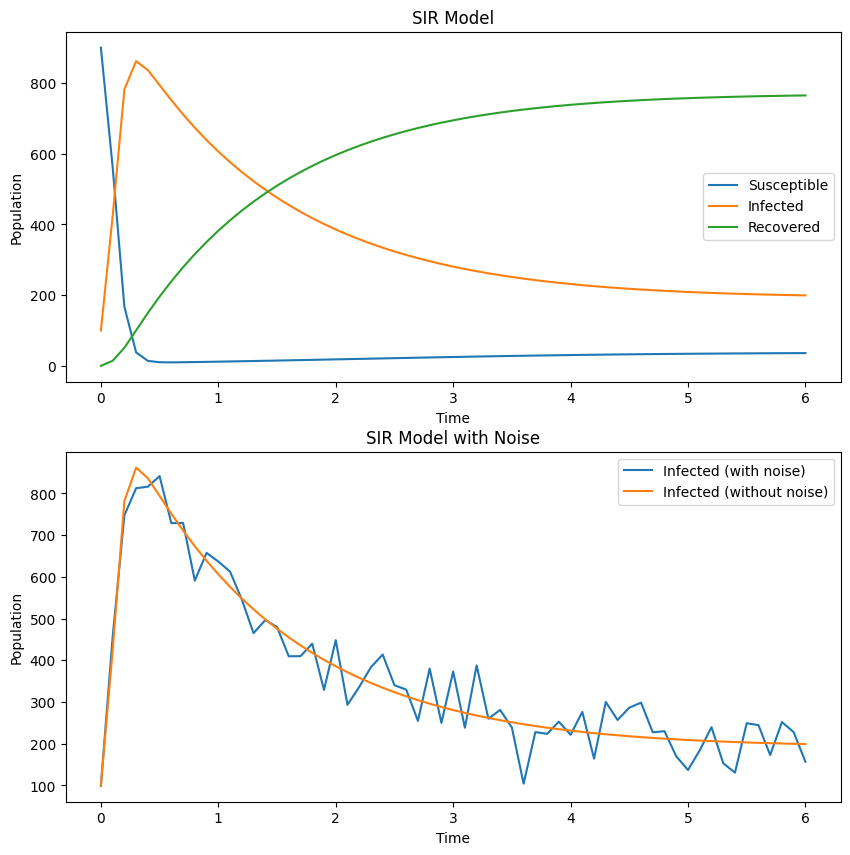

In [ ]:
# extract the solutions
S, I, R = solution.y

# add Gaussian noise to I
Iobs = I + np.random.normal(0, 50, len(timespan))

# plot the SIR on left side plot, and compare plots of un noised I and with noise I on right plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(timespan, S, label='Susceptible')
ax[0].plot(timespan, I, label='Infected')
ax[0].plot(timespan, R, label='Recovered')
ax[0].legend()
ax[0].set_title('SIR Model')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Population')

ax[1].plot(timespan, Iobs, label='Infected (with noise)')
ax[1].plot(timespan, I, label='Infected (without noise)')
ax[1].legend()
ax[1].set_title('SIR Model with Noise')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Population')

plt.show()


### SIR Identifiable Model: DRAM-based Parameter estimation

In [ ]:
# write a function to simulate the trajectory and return back the infected population values
def simulate_trajectory(parameters, y0, timespan_eval, SIR_model):
  N, beta, delta, r, tstart, tend = parameters
  solution = scipy.integrate.solve_ivp(SIR_model, (tstart, tend), y0, method='Radau', rtol=1e-2, atol=1e-3, t_eval=timespan_eval, args=(N, beta, delta, r))
  S, I, R = solution.y
  time = solution.t
  return I, time

In [ ]:
# define the likelihood function
# computes the probability of observing some particular data given the values of the parameters
def likelihood(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model):

  # first predict I using parameters
  I_prediction, I_pred_time = simulate_trajectory(parameters, y0, timespan_eval, SIR_model)

  # if len(I_prediction)!= len(observed_data) interpolate on the timespan_eval to make them of same length
  if len(I_prediction) != len(observed_data):
    I_prediction = np.interp(timespan_eval, I_pred_time, I_prediction)

  # since we add gaussian noise
  # observations follow gaussian distribution centered around prediction values and variance corresponding to noise_sigma
  likelihood_pdf = stats.multivariate_normal.pdf(observed_data, mean=I_prediction, cov= (noise_sigma ** 2)*np.eye(len(I_prediction)))

  return likelihood_pdf

In [ ]:
# define the prior function
def prior(parameters):
  N, beta, delta, r, tstart, tend = parameters

  # we have to compute the probability that beta = beta, delta = delta and r = r
  beta_prob = stats.norm.pdf(beta, loc=0, scale=1)
  delta_prob = stats.norm.pdf(delta, loc=0, scale=1)
  r_prob = stats.norm.pdf(r, loc=0, scale=1)

  return beta_prob * delta_prob * r_prob

# define the posterior function
def posterior(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model):
  likelihood_prob = likelihood(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model)
  prior_prob = prior(parameters)
  posterior_prob = likelihood_prob * prior_prob
  return posterior_prob

In [ ]:
solution_DRAM = []

# Incremental mean and covariance update function using Welford’s method
def update_mean_cov(new_sample, mean, cov, j):
    new_mean = mean + (new_sample - mean) / (j + 1)
    delta = new_sample - mean
    cov = cov + np.outer(delta, delta) * (j / (j + 1))
    return new_mean, cov

# now implement the DRAM algorithm
def DRAM_SIR(initial_params, l1_proposal_covar, k, burnpercent, observed_data, y0, tstart, tend, timespan_eval, noise_sigma, covar_scale_down_l2, SIR_model, d):

  # Initialization parameters
  N, beta_init, delta_init, r_init, tstart, tend = initial_params
  samples = np.zeros((k, d))
  samples[0] = np.array([beta_init, delta_init, r_init])
  mean_iter, covar_iter = samples[0], l1_proposal_covar
  accepted, rejected = 0, 0
  burn = int(burnpercent * k/100)
  epsilon = 0.1
  sd, Id = (2.4**2)/d, np.eye(d)
  current_params = initial_params
  current_posterior = posterior(current_params, observed_data, y0, timespan_eval, noise_sigma, SIR_model)

  for j in tqdm(range(k-1)):

    # level 1 proposal workflow
    next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l1_proposal_covar)

    # compute the posterior ratio and acceptance probability
    parameters_proposal = np.array([N, *next_sample, tstart, tend])
    posterior_proposal = posterior(parameters_proposal, observed_data, y0, timespan_eval, noise_sigma, SIR_model)
    alpha = min(1, (posterior_proposal/current_posterior) + 0.01)

    # accept candidate, i.e store curr = cand with probability alpha
    if np.random.uniform() < alpha:
      samples[j+1] = next_sample
      current_params, current_posterior = parameters_proposal, posterior_proposal
      solution_DRAM.append(next_sample)
      mean_iter, covar_iter = update_mean_cov(next_sample, mean_iter, covar_iter, j)
      l1_proposal_covar = sd * covar_iter / (j + 1) + epsilon * sd * Id
      accepted += 1

    else:
      # create l2_proposal_covariance
      l2_proposal_covar = covar_scale_down_l2 * l1_proposal_covar

      # generate next sample from l2_proposal
      l2_next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l2_proposal_covar)

      # compute the posterior ratio and acceptance probability
      l2_parameters_proposal = np.array([N, *l2_next_sample, tstart, tend])
      l2_posterior_proposal = posterior(l2_parameters_proposal, observed_data, y0, timespan_eval, noise_sigma, SIR_model)
      l2_alpha = min(1, l2_posterior_proposal/current_posterior)

      # accept candidate, i.e store curr = cand with probability alpha2
      if np.random.uniform() < l2_alpha:
        samples[j+1] = l2_next_sample
        solution_DRAM.append(l2_next_sample)
        current_params, current_posterior = l2_parameters_proposal, l2_posterior_proposal
        mean_iter, covar_iter = update_mean_cov(next_sample, mean_iter, covar_iter, j)
        l1_proposal_covar = sd * covar_iter / (j + 1) + epsilon * sd * Id
        accepted += 1

      else:
        # reject the next sample, add current sample to samples again
        samples[j+1] = samples[j]
        solution_DRAM.append(samples[j])
        rejected += 1

  # return the samples after burn-in
  return samples[burn:], accepted, rejected

### SIR Identifiable Version Model Execution

In [ ]:
N, beta_init, delta_init, r_init, tstart, tend = 1000, 0.1, 0.41, 0.1, 0, 6
initial_params = np.array([N, beta_init, delta_init, r_init, tstart, tend])
tru_values = np.array([0.02, 0.15, 0.6])
initial_l1_proposal_covar = np.eye(3)
number_of_iterations = 50000
burn_purcent = 20
observed_data = Iobs
y0 = np.array([S0, I0, R0])
timespan_eval = np.linspace(0, 6, 61)
noise_sigma = 50
covar_scale_down_l2 = 0.02
dim = 3

In [ ]:
DRAM_SIR_chain = DRAM_SIR(initial_params, initial_l1_proposal_covar, number_of_iterations, burn_purcent, observed_data, y0, tstart, tend, timespan_eval, noise_sigma, covar_scale_down_l2, SIR_model, dim)

  0%|          | 0/49999 [00:00<?, ?it/s]<ipython-input-298-c7a43c386aaf>:33: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, (posterior_proposal/current_posterior) + 0.01)
  0%|          | 85/49999 [00:11<1:56:30,  7.14it/s]


ValueError: array must not contain infs or NaNs

In [ ]:
# save the variable DRAM_SIR_chain in pickle
#with open('DRAM_SIR_chain.pkl', 'wb') as f:
#    pickle.dump(DRAM_SIR_chain, f)
# load the DRAM_SIR_chain pickle file
with open('DRAM_SIR_chain.pkl', 'rb') as f:
    DRAM_SIR_chain = pickle.load(f)

In [ ]:
DRAM_SIR_chain_vals, DRAM_SIR_ID_accepted, DRAM_SIR_ID_rejected = DRAM_SIR_chain

### SIR Identifiable Version Model Diagnostics

#### 1D Marginals

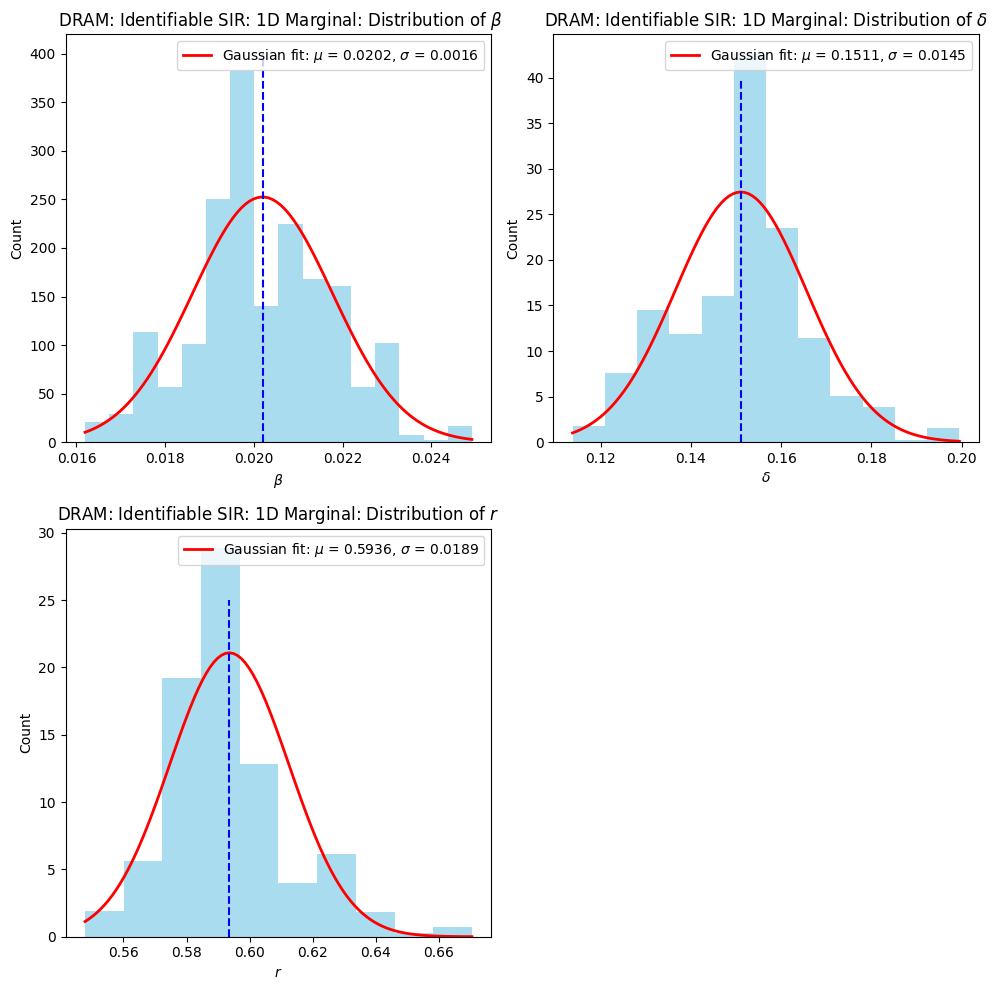

In [ ]:
# plot 1d marginals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
bins = int(number_of_iterations/3000)

ax[0, 0].hist(DRAM_SIR_chain_vals[:, 0], bins, density=True, alpha=0.7, color='skyblue')
mubeta, stdbeta = stats.norm.fit(DRAM_SIR_chain_vals[:, 0])
ks_stat, p_value = stats.kstest(data, stats.norm.cdf, args=params)
xbeta = np.linspace(np.min(DRAM_SIR_chain_vals[:, 0]), np.max(DRAM_SIR_chain_vals[:, 0]), 100)
ax[0, 0].plot(xbeta, stats.norm.pdf(xbeta, mubeta, stdbeta), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mubeta, 4)}, $\sigma$ = {np.round(stdbeta, 4)}')
ax[0, 0].vlines(mubeta, 0, 400, linestyles='dashed', colors='blue')
ax[0, 0].set_title(r" DRAM: Identifiable SIR: 1D Marginal: Distribution of $\beta$")
ax[0, 0].set_xlabel(r"$\beta$")
ax[0, 0].set_ylabel("Count")
ax[0, 0].legend()

ax[0, 1].hist(DRAM_SIR_chain_vals[:, 1], 12, density=True, alpha=0.7, color='skyblue')
mudelta, stddelta = stats.norm.fit(DRAM_SIR_chain_vals[:, 1])
xdelta = np.linspace(np.min(DRAM_SIR_chain_vals[:, 1]), np.max(DRAM_SIR_chain_vals[:, 1]), 100)
ax[0, 1].plot(xdelta, stats.norm.pdf(xdelta, mudelta, stddelta), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mudelta, 4)}, $\sigma$ = {np.round(stddelta, 4)}')
ax[0, 1].vlines(mudelta, 0, 40, linestyles='dashed', colors='blue')
ax[0, 1].set_title(r"DRAM: Identifiable SIR: 1D Marginal: Distribution of $\delta$")
ax[0, 1].set_xlabel(r"$\delta$")
ax[0, 1].set_ylabel("Count")
ax[0, 1].legend()

ax[1, 0].hist(DRAM_SIR_chain_vals[:, 2], 10, density=True, alpha=0.7, color='skyblue')
mur, stdr = stats.norm.fit(DRAM_SIR_chain_vals[:, 2])
xr = np.linspace(np.min(DRAM_SIR_chain_vals[:, 2]), np.max(DRAM_SIR_chain_vals[:, 2]), 100)
ax[1, 0].plot(xr, stats.norm.pdf(xr, mur, stdr), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mur, 4)}, $\sigma$ = {np.round(stdr, 4)}')
ax[1, 0].vlines(mur, 0, 25, linestyles='dashed', colors='blue')
ax[1, 0].set_title(r"DRAM: Identifiable SIR: 1D Marginal: Distribution of $r$")
ax[1, 0].set_xlabel(r"$r$")
ax[1, 0].set_ylabel("Count")
ax[1, 0].legend()

ax[1, 1].axis("off")

plt.tight_layout()
plt.savefig('DRAM_SIR_chain_1d_marginals.png', dpi=300)
plt.show()

#### Auto-Corelation Plots

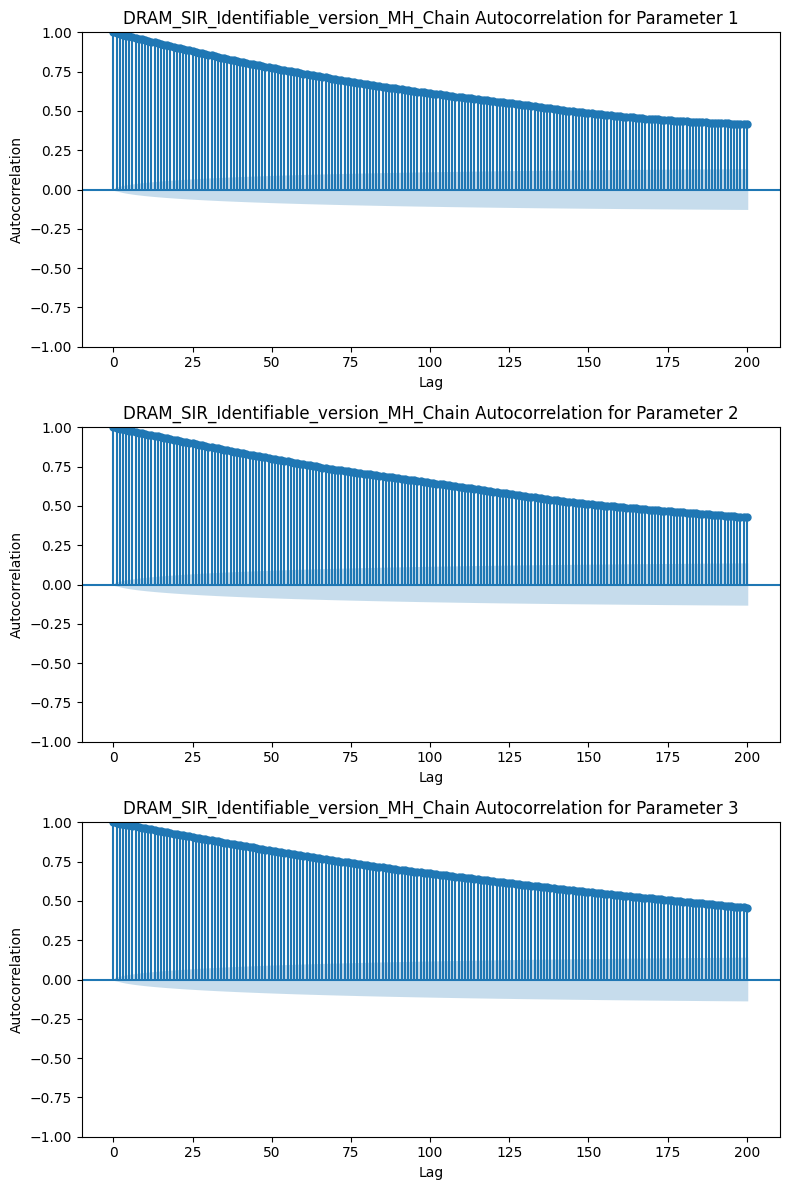

In [ ]:
plot_autocorrelation(DRAM_SIR_chain_vals, "DRAM_SIR_Identifiable_version_MH_Chain", max_lag=200)

#### Integrated Auto-corelation values

In [ ]:
calculate_iat(DRAM_SIR_chain_vals)

[88.98752524218455, 90.61688777442242, 91.61446609607549]

#### Acceptance Ratios


In [ ]:
# compute acceptance ratio of MH chain
DRAM_SIR_ID_acceptance_ratio = DRAM_SIR_ID_accepted/DRAM_SIR_chain_vals.shape[0]
print(f"Acceptance Ratio: {DRAM_SIR_ID_acceptance_ratio}")

Acceptance Ratio: 0.004925


## B: SIR Non-Identifiable Version

### SIR Non-Identifiable Version Model Implementation

In [ ]:
def SIR_non_ID_model(t, y, N, gamma, kappa, delta, r):
  S, I, R = y # unpack the y variable or state
  dSdt = -1*gamma*kappa*I*S - delta*S + delta*N
  dIdt = gamma*kappa*I*S - (r+delta)*I
  dRdt = r*I - delta*R
  return np.array([dSdt, dIdt, dRdt])

In [ ]:
# write a function to simulate the trajectory and return back the infected population values
def simulate_trajectory_non_ID(parameters, y0, timespan_eval, SIR_non_ID_model):
  N, gamma, kappa, delta, r, tstart, tend = parameters
  solution = scipy.integrate.solve_ivp(SIR_non_ID_model, (tstart, tend), y0, method='BDF', rtol=1e-2, atol=1e-3, t_eval=timespan_eval, args=(N, gamma, kappa, delta, r))
  S, I, R = solution.y
  time = solution.t
  return I, time

In [ ]:
# define the likelihood function
# computes the probability of observing some particular data given the values of the parameters
def likelihood_non_ID(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model):

  # first predict I using parameters
  I_prediction, I_pred_time = simulate_trajectory_non_ID(parameters, y0, timespan_eval, SIR_model)

  # if len(I_prediction)!= len(observed_data) interpolate on the timespan_eval to make them of same length
  if len(I_prediction) != len(observed_data):
    I_prediction = np.interp(timespan_eval, I_pred_time, I_prediction)

  # since we add gaussian noise
  # observations follow gaussian distribution centered around prediction values and variance corresponding to noise_sigma
  likelihood_pdf = stats.multivariate_normal.pdf(observed_data, mean=I_prediction, cov= (noise_sigma ** 2)*np.eye(len(I_prediction)))

  return likelihood_pdf

In [ ]:
# define the prior function
def prior_non_ID(parameters):
  N, gamma, kappa, delta, r, tstart, tend = parameters

  # setting gaussian priors
  gamma_prob = stats.norm.pdf(gamma, loc=0, scale=100)
  kappa_prob = stats.norm.pdf(kappa, loc=0, scale=100)
  delta_prob = stats.norm.pdf(delta, loc=0, scale=1)
  r_prob = stats.norm.pdf(r, loc=0, scale=1)

  return gamma_prob * kappa_prob * delta_prob * r_prob

# define the posterior function
def posterior_non_ID(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model):
  likelihood_prob = likelihood_non_ID(parameters, observed_data, y0, timespan_eval, noise_sigma, SIR_model)
  prior_prob = prior_non_ID(parameters)
  posterior_prob = likelihood_prob * prior_prob
  return posterior_prob

In [ ]:
solution_DRAM_non_ID = []

# Incremental mean and covariance update function using Welford’s method
def update_mean_cov_non_ID(new_sample, mean, cov, j):
    new_mean = mean + (new_sample - mean) / (j + 1)
    delta = new_sample - mean
    cov = cov + np.outer(delta, delta) * (j / (j + 1))
    return new_mean, cov

# now implement the DRAM algorithm
def DRAM_SIR_non_ID(initial_params, l1_proposal_covar, k, burnpercent, observed_data, y0, tstart, tend, timespan_eval, noise_sigma, covar_scale_down_l2, model, d):

  # Initialization parameters
  N, gamma_init, kappa_init, delta_init, r_init, tstart, tend = initial_params
  samples = np.zeros((k, d))
  samples[0] = np.array([gamma_init, kappa_init, delta_init, r_init])
  mean_iter, covar_iter = samples[0], l1_proposal_covar
  accepted, rejected = 0, 0
  burn = int(burnpercent * k/100)
  epsilon = 0.1
  sd, Id = (2.4**2)/d, np.eye(d)
  current_params = initial_params
  current_posterior = posterior_non_ID(current_params, observed_data, y0, timespan_eval, noise_sigma, model)

  for j in tqdm(range(k-1)):

    # level 1 proposal workflow
    next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l1_proposal_covar)

    # compute the posterior ratio and acceptance probability
    parameters_proposal = np.array([N, *next_sample, tstart, tend])
    posterior_proposal = posterior_non_ID(parameters_proposal, observed_data, y0, timespan_eval, noise_sigma, model)
    alpha = min(1, posterior_proposal/current_posterior) # add a small non-zero constant to ensure no divisions by zero occur

    # accept candidate, i.e store curr = cand with probability alpha
    if np.random.uniform() < alpha:
      samples[j+1] = next_sample
      current_params, current_posterior = parameters_proposal, posterior_proposal
      solution_DRAM_non_ID.append(next_sample)
      mean_iter, covar_iter = update_mean_cov_non_ID(next_sample, mean_iter, covar_iter, j)
      l1_proposal_covar = sd * covar_iter / (j + 1) + epsilon * sd * Id
      accepted += 1

    else:
      # create l2_proposal_covariance
      l2_proposal_covar = covar_scale_down_l2 * l1_proposal_covar

      # generate next sample from l2_proposal
      l2_next_sample = stats.multivariate_normal.rvs(mean=samples[j], cov=l2_proposal_covar)

      # compute the posterior ratio and acceptance probability
      l2_parameters_proposal = np.array([N, *l2_next_sample, tstart, tend])
      l2_posterior_proposal = posterior_non_ID(l2_parameters_proposal, observed_data, y0, timespan_eval, noise_sigma, model)
      l2_alpha = min(1, l2_posterior_proposal/current_posterior)

      # accept candidate, i.e store curr = cand with probability alpha2
      if np.random.uniform() < l2_alpha:
        samples[j+1] = l2_next_sample
        solution_DRAM_non_ID.append(l2_next_sample)
        current_params, current_posterior = l2_parameters_proposal, l2_posterior_proposal
        mean_iter, covar_iter = update_mean_cov_non_ID(next_sample, mean_iter, covar_iter, j)
        l1_proposal_covar = sd * covar_iter / (j + 1) + epsilon * sd * Id
        accepted += 1

      else:
        # reject the next sample, add current sample to samples again
        samples[j+1] = samples[j]
        solution_DRAM_non_ID.append(samples[j])
        rejected += 1

  # return the samples after burn-in
  return samples[burn:], accepted, rejected

### SIR Non-Identifiable Version Model Execution

The parameter $\beta$ is essentially represented as $\beta = \gamma \times \kappa$. Hence in the non-identifiable version we have the parameters $\gamma, \kappa, \delta, r$.

In [ ]:
N, gamma_init, kappa_init, delta_init, r_init, tstart, tend = 1000, 0.1, 0.15, 0.3, 0.2, 0, 6
initial_params_non_ID = np.array([N, gamma_init, kappa_init, delta_init, r_init, tstart, tend])
tru_values_non_ID = np.array([0.02, 0.15, 0.6])
number_of_iterations_non_ID = 100000
burn_purcent_non_ID = 20
observed_data = Iobs
y0 = np.array([S0, I0, R0])
timespan_eval = np.linspace(0, 6, 61)
noise_sigma = 50
covar_scale_down_l2 = 0.02
dim = 4
initial_l1_proposal_covar_non_ID = np.eye(dim)*0.2

In [ ]:
DRAM_SIR_chain_non_ID = DRAM_SIR_non_ID(initial_params_non_ID, initial_l1_proposal_covar_non_ID, number_of_iterations_non_ID, burn_purcent_non_ID, observed_data, y0, tstart, tend, timespan_eval, noise_sigma, covar_scale_down_l2, SIR_non_ID_model, dim)

  0%|          | 0/99999 [00:00<?, ?it/s]<ipython-input-6-a174979f11e6>:33: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, posterior_proposal/current_posterior) # add a small non-zero constant to ensure no divisions by zero occur
<ipython-input-6-a174979f11e6>:33: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, posterior_proposal/current_posterior) # add a small non-zero constant to ensure no divisions by zero occur
100%|██████████| 99999/99999 [54:37<00:00, 30.51it/s]


### SIR Non-Identifiable Version Model Diagnostics

In [ ]:
# save variable DRAM_SIR_chain_non_ID with pickle
with open('DRAM_SIR_chain_non_ID.pkl', 'wb') as f:
    pickle.dump(DRAM_SIR_chain_non_ID, f)

In [ ]:
# read the DRAM_SIR_chain_non_ID variable from pickle file
with open('DRAM_SIR_chain_non_ID.pkl', 'rb') as f:
    DRAM_SIR_chain_non_ID = pickle.load(f)

In [ ]:
DRAM_SIR_chain_non_ID_vals, DRAM_SIR_non_ID_ID_accepted, DRAM_SIR_non_ID_ID_rejected = DRAM_SIR_chain_non_ID

#### 1D Marginals

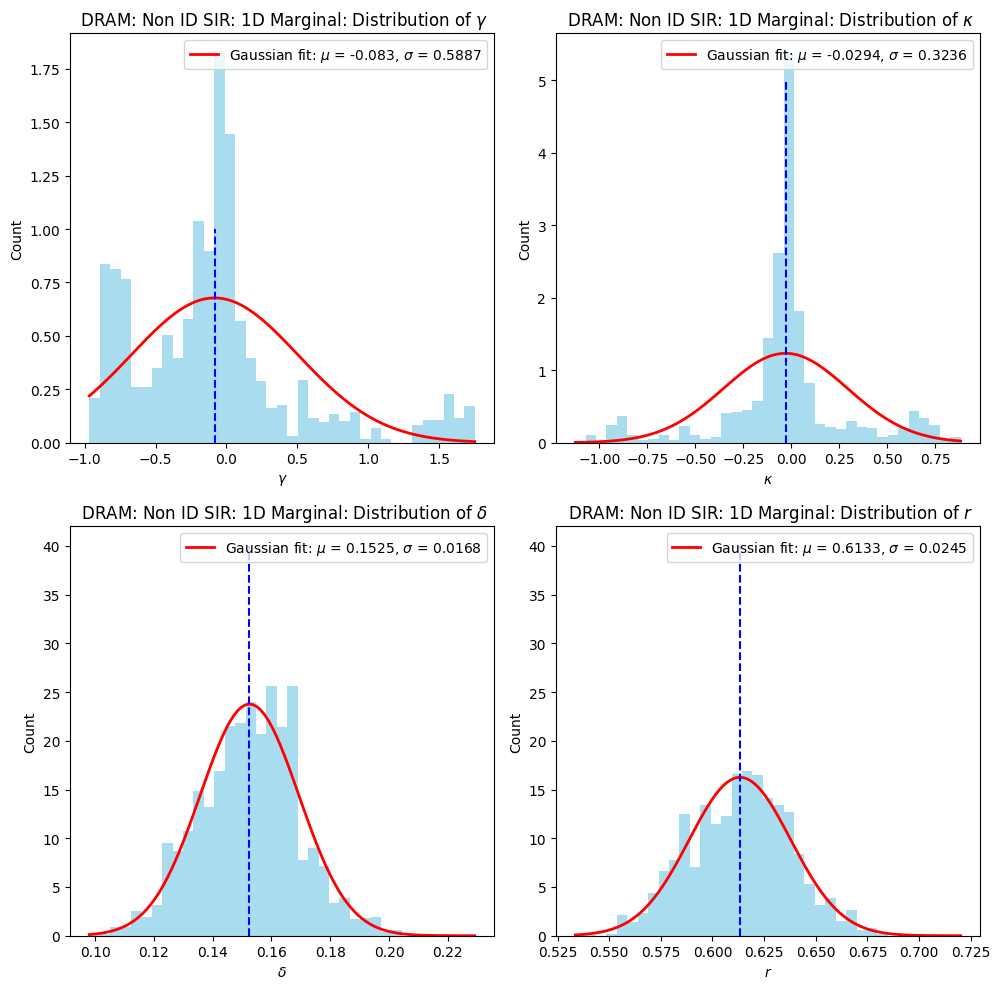

In [ ]:
# plot 1d marginals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
bins = int(number_of_iterations_non_ID/2700)

ax[0, 0].hist(DRAM_SIR_chain_non_ID_vals[:, 0], bins, density=True, alpha=0.7, color='skyblue')
mugamma, stdgamma = stats.norm.fit(DRAM_SIR_chain_non_ID_vals[:, 0])
xgamma = np.linspace(np.min(DRAM_SIR_chain_non_ID_vals[:, 0]), np.max(DRAM_SIR_chain_non_ID_vals[:, 0]), 100)
ax[0, 0].plot(xgamma, stats.norm.pdf(xgamma, mugamma, stdgamma), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mugamma, 4)}, $\sigma$ = {np.round(stdgamma, 4)}')
ax[0, 0].vlines(mugamma, 0, 1, linestyles='dashed', colors='blue')
ax[0, 0].set_title(r" DRAM: Non ID SIR: 1D Marginal: Distribution of $\gamma$")
ax[0, 0].set_xlabel(r"$\gamma$")
ax[0, 0].set_ylabel("Count")
ax[0, 0].legend()

ax[0, 1].hist(DRAM_SIR_chain_non_ID_vals[:, 1], bins, density=True, alpha=0.7, color='skyblue')
mukappa, stdkappa = stats.norm.fit(DRAM_SIR_chain_non_ID_vals[:, 1])
xkappa = np.linspace(np.min(DRAM_SIR_chain_non_ID_vals[:, 1]), np.max(DRAM_SIR_chain_non_ID_vals[:, 1]), 100)
ax[0, 1].plot(xkappa, stats.norm.pdf(xkappa, mukappa, stdkappa), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mukappa, 4)}, $\sigma$ = {np.round(stdkappa, 4)}')
ax[0, 1].vlines(mukappa, 0, 5, linestyles='dashed', colors='blue')
ax[0, 1].set_title(r" DRAM: Non ID SIR: 1D Marginal: Distribution of $\kappa$")
ax[0, 1].set_xlabel(r"$\kappa$")
ax[0, 1].set_ylabel("Count")
ax[0, 1].legend()

ax[1, 0].hist(DRAM_SIR_chain_non_ID_vals[:, 2], bins, density=True, alpha=0.7, color='skyblue')
mudelta, stddelta = stats.norm.fit(DRAM_SIR_chain_non_ID_vals[:, 2])
xdelta = np.linspace(np.min(DRAM_SIR_chain_non_ID_vals[:, 2]), np.max(DRAM_SIR_chain_non_ID_vals[:, 2]), 100)
ax[1, 0].plot(xdelta, stats.norm.pdf(xdelta, mudelta, stddelta), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mudelta, 4)}, $\sigma$ = {np.round(stddelta, 4)}')
ax[1, 0].vlines(mudelta, 0, 40, linestyles='dashed', colors='blue')
ax[1, 0].set_title(r" DRAM: Non ID SIR: 1D Marginal: Distribution of $\delta$")
ax[1, 0].set_xlabel(r"$\delta$")
ax[1, 0].set_ylabel("Count")
ax[1, 0].legend()

ax[1, 1].hist(DRAM_SIR_chain_non_ID_vals[:, 3], bins, density=True, alpha=0.7, color='skyblue')
mur, stdr = stats.norm.fit(DRAM_SIR_chain_non_ID_vals[:, 3])
xr = np.linspace(np.min(DRAM_SIR_chain_non_ID_vals[:, 3]), np.max(DRAM_SIR_chain_non_ID_vals[:, 3]), 100)
ax[1, 1].plot(xr, stats.norm.pdf(xr, mur, stdr), 'r-', lw=2, label=f'Gaussian fit: $\mu$ = {np.round(mur, 4)}, $\sigma$ = {np.round(stdr, 4)}')
ax[1, 1].vlines(mur, 0, 40, linestyles='dashed', colors='blue')
ax[1, 1].set_title(r" DRAM: Non ID SIR: 1D Marginal: Distribution of $r$")
ax[1, 1].set_xlabel(r"$r$")
ax[1, 1].set_ylabel("Count")
ax[1, 1].legend()


plt.tight_layout()
plt.savefig('DRAM_SIR_Non_ID_chain_1d_marginals.png', dpi=300)
plt.show()

#### Auto-co-relation plots

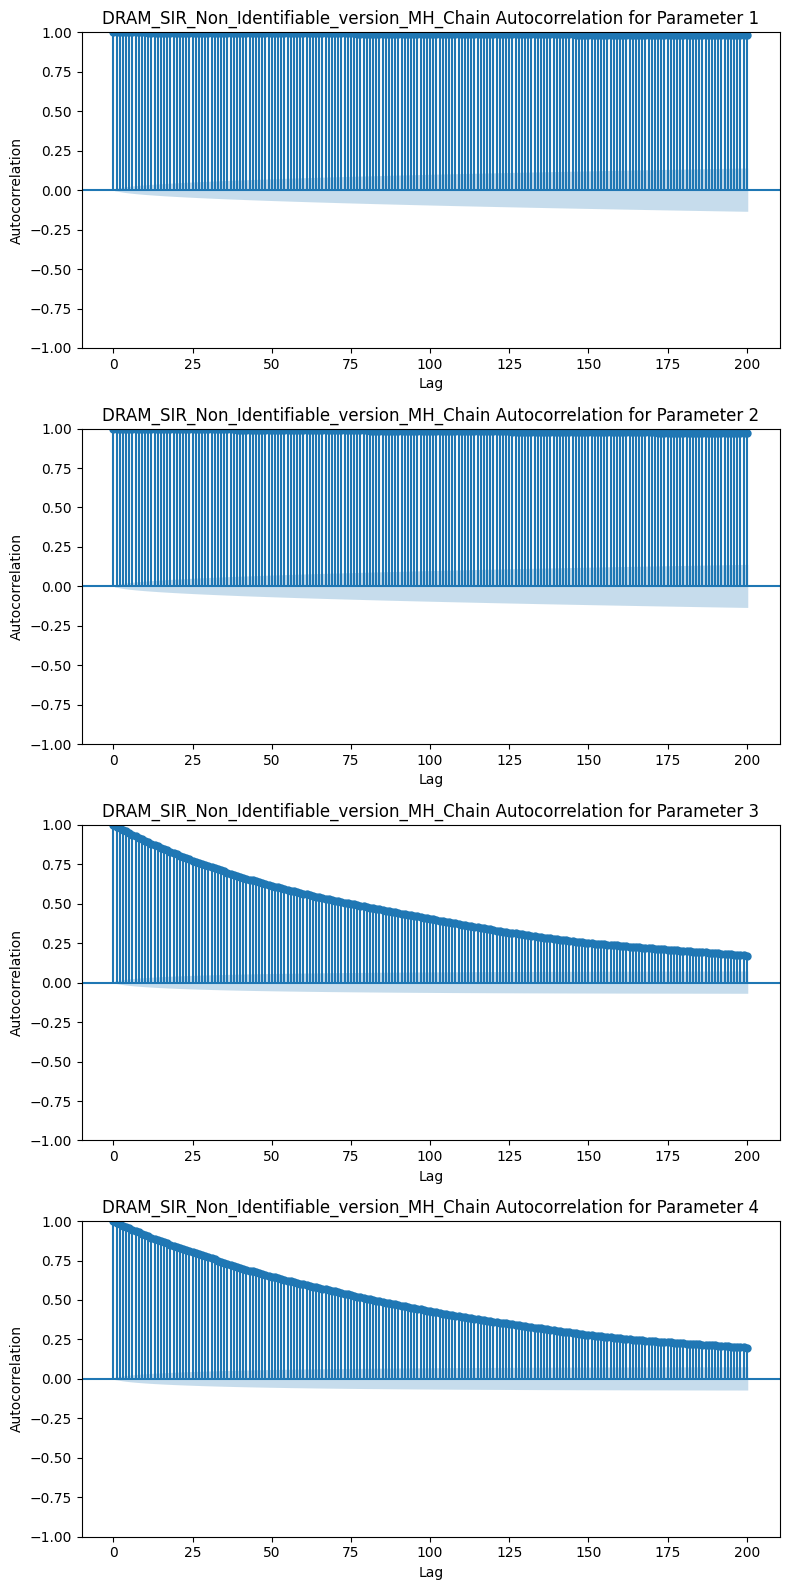

In [ ]:
plot_autocorrelation(DRAM_SIR_chain_non_ID_vals, "DRAM_SIR_Non_Identifiable_version_MH_Chain", max_lag=200)

#### Integrated Auto-corelation values

In [ ]:
calculate_iat(DRAM_SIR_chain_non_ID_vals)

[100.74981879540127, 100.61008157411942, 79.1088997616447, 81.50655454758493]

#### Acceptance Ratios

In [ ]:
# compute acceptance ratio of MH chain
DRAM_SIR_Non_ID_acceptance_ratio = DRAM_SIR_non_ID_ID_accepted/DRAM_SIR_chain_non_ID_vals.shape[0]
print(f"Acceptance Ratio: {DRAM_SIR_Non_ID_acceptance_ratio}")

Acceptance Ratio: 0.012925


## Truth vs Predictive Dynamics


In [ ]:
# define ground truth parameters and initial values
beta_truth, delta_truth, r_truth = 0.02, 0.15, 0.6
parameter_truth = np.array([beta_truth, delta_truth, r_truth])
truth_params = np.array([N, *parameter_truth, tstart, tend])
S0, I0, R0 = 900, 100, 0
y0 = np.array([S0, I0, R0])
timespan_eval = np.linspace(0, 6, 61)
N = 1000
tstart, tend = 0, 6

### SIR Identifiable Model

In [ ]:
def plot_prior_posterior(n):
  plt.figure(figsize=(10, 6))
  for i in range(n):

    # generate samples of beta, delta, r from the prior distribution
    prior_sample = stats.multivariate_normal.rvs(mean=np.array([0, 0, 0]), cov=np.eye(3))
    prior_params = np.array([N, *prior_sample, tstart, tend])

    # generate posterior samples
    SIR_ID_posterior_beta = stats.norm.rvs(loc=0.02, scale=0.0016)
    SIR_ID_posterior_delta = stats.norm.rvs(loc=0.1511, scale=0.0145)
    SIR_ID_posterior_r = stats.norm.rvs(loc=0.5936, scale=0.0189)

    posterior_params = np.array([N, SIR_ID_posterior_beta, SIR_ID_posterior_delta, SIR_ID_posterior_r, tstart, tend])

    # simulate prior
    I_prior, time_prior = simulate_trajectory(prior_params, y0, timespan_eval, SIR_model)
    I_posterior, time_posterior = simulate_trajectory(posterior_params, y0, timespan_eval, SIR_model)
    I_truth, time_truth = simulate_trajectory(truth_params, y0, timespan_eval, SIR_model)

    plt.figure(figsize=(10, 6))
    plt.plot(timespan_eval, I_truth, label='Truth', color='blue', linestyle='-', linewidth=1.5)
    plt.plot(timespan_eval, I_prior, label='Prior', color='gray', linestyle='--', linewidth=2)
    plt.plot(timespan_eval, I_posterior, label='Posterior', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title('Truth vs. Prior vs. Posterior Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1000x600 with 0 Axes>

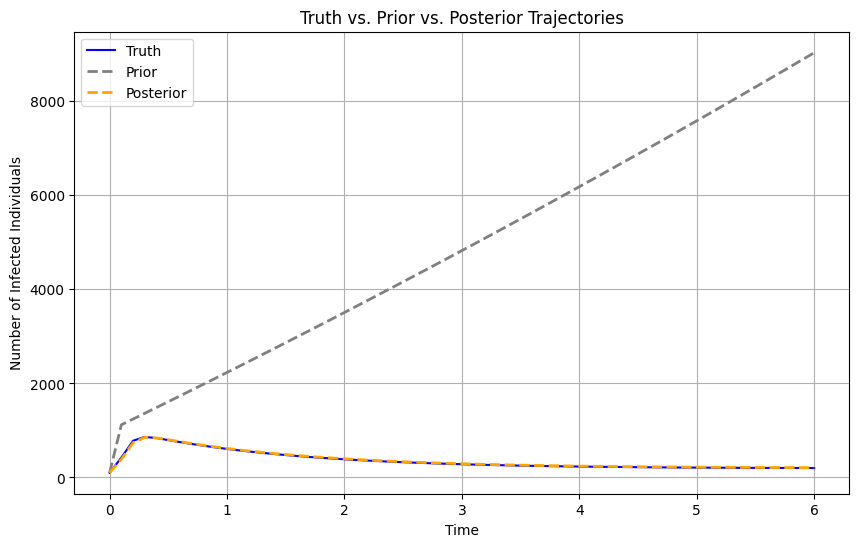

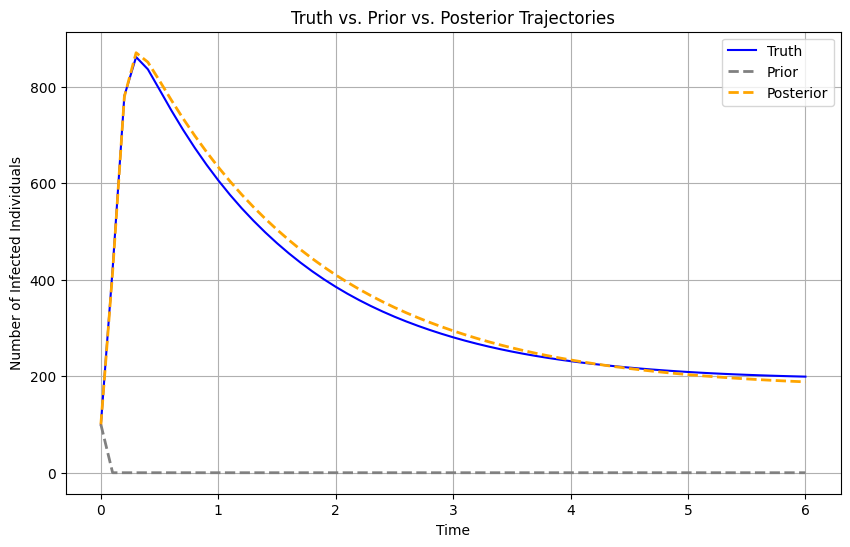

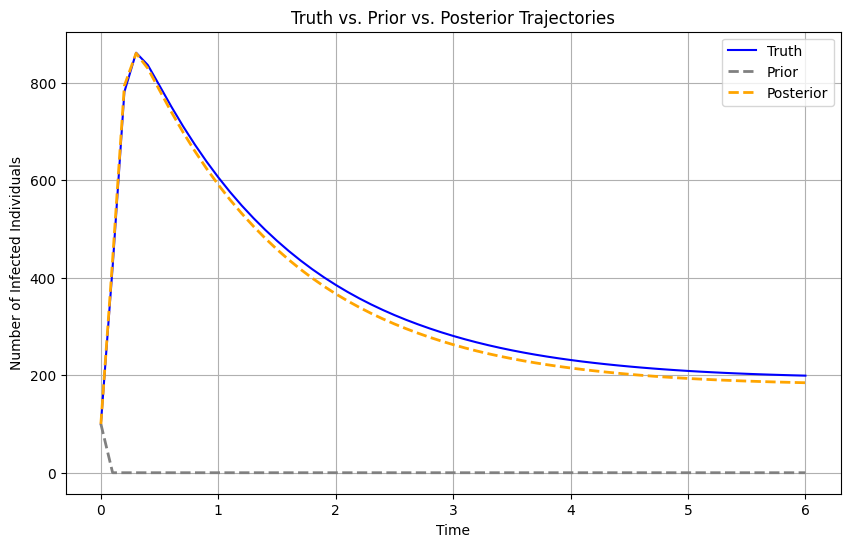

In [ ]:
plot_prior_posterior(3)

### SIR Non-Identifiable Model

In [ ]:
def plot_prior_posterior_non_ID(n):
  plt.figure(figsize=(10, 6))
  for i in range(n):

    # generate samples of gamma, kappa, delta, r from the prior distribution
    prior_sample = stats.multivariate_normal.rvs(mean=np.array([0, 0, 0, 0]), cov=np.eye(4))
    prior_params = np.array([N, *prior_sample, tstart, tend])

    # generate posterior samples
    SIR_ID_posterior_gamma = stats.norm.rvs(loc=-0.083, scale=0.5887)
    SIR_ID_posterior_kappa = stats.norm.rvs(loc=-0.0294, scale=0.3236)
    SIR_ID_posterior_delta = stats.norm.rvs(loc=0.1525, scale=0.0168)
    SIR_ID_posterior_r = stats.norm.rvs(loc=0.6133, scale=0.0245)

    posterior_params = np.array([N, SIR_ID_posterior_gamma, SIR_ID_posterior_kappa, SIR_ID_posterior_delta, SIR_ID_posterior_r, tstart, tend])

    # simulate
    I_prior, time_prior = simulate_trajectory_non_ID(prior_params, y0, timespan_eval, SIR_non_ID_model)
    I_posterior, time_posterior = simulate_trajectory_non_ID(posterior_params, y0, timespan_eval, SIR_non_ID_model)
    I_truth, time_truth = simulate_trajectory(truth_params, y0, timespan_eval, SIR_model)

    plt.figure(figsize=(10, 6))
    plt.plot(timespan_eval, I_truth, label='Truth', color='blue', linestyle='-', linewidth=1.5)
    plt.plot(timespan_eval, I_prior, label='Prior', color='gray', linestyle='--', linewidth=2)
    plt.plot(timespan_eval, I_posterior, label='Posterior', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title('Truth vs. Prior vs. Posterior Trajectories: Non ID SIR')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1000x600 with 0 Axes>

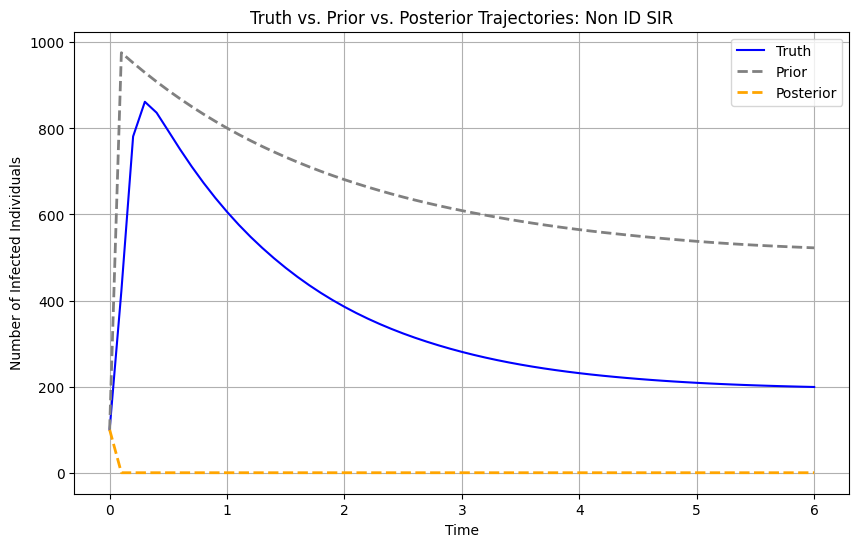

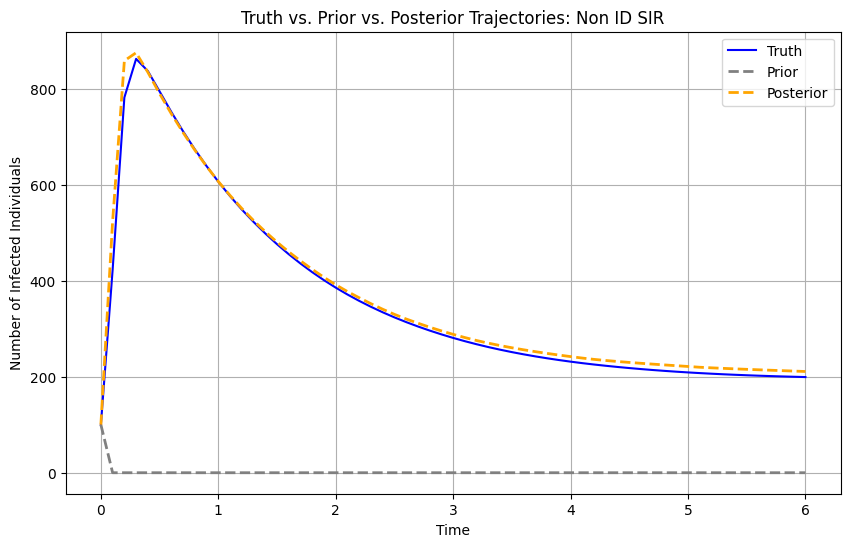

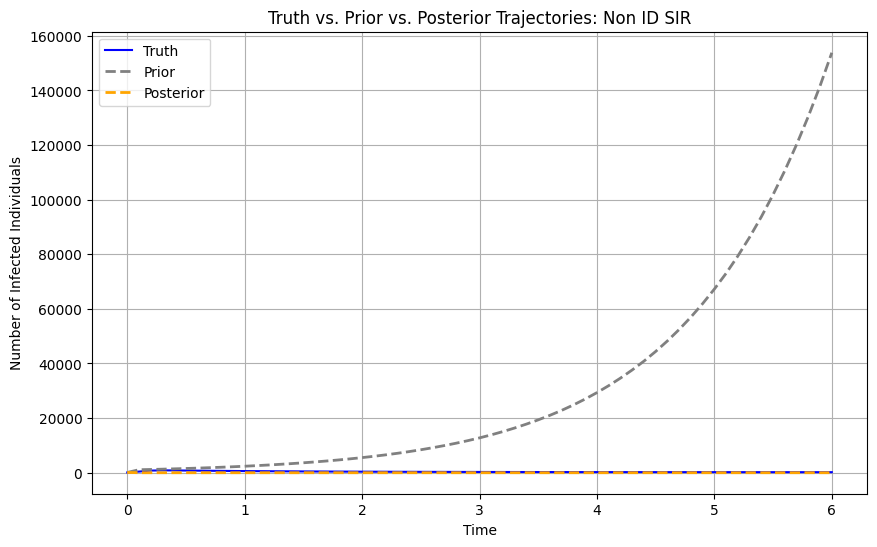

In [ ]:
plot_prior_posterior_non_ID(3)